In [1]:
import torch
import warnings

warnings.filterwarnings("ignore")

from torch import nn
from common.conv2d_img2col import Conv2dImg2Col
import copy
import os
import pytorch_lightning as pl

os.chdir("/workspaces/conv2d_reimagined")

from experiments.conv2d_img2col_QAT import create_dummy_dataloader
from torch.quantization.quantize_fx import convert_fx

from src.models.dummy import DummyModel
from src.core.latency import (
    latency_cpu,
    latency_gpu,
    latency_cpu_profiler,
    latency_gpu_event,
)
from src.utils import basicconv_model, custom_conv_model, compare_models
from src.core.quant import setup_qat_for_model
from src.core.metric_writer import LatencyMetricsWriter
from src.utils import analyze_benchmark_data

WARM_N = 5
BENCH_N = 50
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [2]:
def get_dummy_model_input(batch=4, replace_conv2d=False):
    model = DummyModel(replaced_conv=replace_conv2d)
    input = torch.randn(batch, 3, 64, 64, requires_grad=False)

    model.to(device)
    input = input.to(device)

    model.eval()
    lcpu = latency_cpu(model, input, warmup_n=10, benchmark_n=30)
    lgpu = latency_gpu(model, input, warmup_n=10, benchmark_n=30)
    lcpu_p1 = latency_cpu_profiler(model, input, warmup_n=10, benchmark_n=30)
    print(lcpu_p1.key_averages().table(sort_by="self_cpu_time_total", row_limit=5))
    return model, input

## Simple Sequential - test with different kernel size

In [ ]:
batch = 2

model = nn.Sequential(
    Conv2dImg2Col(3, 16, kernel_size=3, stride=1, padding=1, bias=True),
    nn.ReLU(),
    Conv2dImg2Col(16, 32, kernel_size=3, stride=1, padding=1, bias=True),
    nn.ReLU(),
    Conv2dImg2Col(32, 64, kernel_size=3, stride=1, padding=1, bias=True),
)
model_ = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=True),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=True),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=True),
)
model_name = "Simple_Conv2dImg2Col_Network"
model_name_ = "Simple_Conv2d_Network"
input = torch.randn(batch, 3, 180, 320, requires_grad=False)

model.to(device)
input = input.to(device)

In [3]:
import time


def eval_simple_sequential():
    writer = LatencyMetricsWriter("sequential_model_latency_dummy.csv")
    for key in ["custom_conv_model", "basicconv_model"]:
        for k in [1, 3, 5, 7, 9, 11]:
            if key == "custom_conv_model":
                model = custom_conv_model(k)
            else:
                model = basicconv_model(k)
            for bs in [1, 2, 4, 8, 16, 32, 64]:

                input = torch.randn(bs, 3, 32, 32, requires_grad=False)
                model.to(device)
                input = input.to(device)
                # collect cpu gpu stat for model
                lcpu_p1 = latency_cpu_profiler(
                    model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
                )
                gpu_mean_p1, gpu_std_p1 = latency_gpu(
                    model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
                )

                writer.record_metrics(
                    model=model,
                    model_name=f"{key}_k{k}_bs{bs}",
                    batch_size=input.shape[0],
                    precision="fp32",
                    input_shape=input.shape,
                    cpu_profiler=lcpu_p1,
                    gpu_latency=(gpu_mean_p1, gpu_std_p1),
                    notes=f"Simple Sequential model with {key} and kernel_size={k}",
                )
                del lcpu_p1
            # clean up
            del model
            del input
            torch.cuda.empty_cache()


def visualize_result(key):
    compare_models("sequential_model_latency_dummy.csv", key)


# eval_simple_sequential()

In [ ]:
visualize_result(key="latency_gpu_mean_ms")
visualize_result(key="latency_cpu_ms")

In [12]:
latency_gpu(model, input, warmup_n=10, benchmark_n=10)
latency_gpu_event(model, input, warmup=10, repeat=10)

Start GPU benchmark with input shape: torch.Size([2, 3, 320, 320]) cuda:0
7.003ms +- 3.361ms


(12.413007736206055, 5.0858612060546875)

In [5]:
latency_cpu(model, input, warmup_n=10, benchmark_n=30)

Start CPU benchmark with input shape: torch.Size([2, 3, 320, 320]) cpu
23.287ms +- 8.167ms


(23.287114333288628, 8.16671405879791)

In [ ]:
model.to("cpu")
input = input.to("cpu")
print(input.device)
prof = latency_cpu_profiler(model, input, warmup_n=10, benchmark_n=30)
print(
    prof.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=15
    )
)

## Simple Model

In [3]:
model, input = get_dummy_model_input(16)
print("\n--- post training dynamic/weight_only quantization ---")

# config = get_default_qat_qconfig_mapping("x86") # qnnpack
prepared_model = copy.deepcopy(model)
prepared_model = setup_qat_for_model(prepared_model, input, config=None)
prepared_model.eval()
print()

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
53.059ms +- 3.258ms
Start GPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cuda:0
1.209ms +- 0.379ms


/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")


--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
        aten::mkldnn_convolution        67.71%      37.652ms        68.03%      37.830ms      12.610ms      28.00 Mb           0 b             3  
                 aten::clamp_min        14.94%       8.309ms        14.94%       8.309ms       2.770ms      28.00 Mb      28.00 Mb             3  
                 model_inference         5.02%       2.789ms       100.00%      55.607ms      55.607ms           0 b     -84.00 Mb             1  
         aten::native_batch_norm         3.91%       2.172ms         4.00%       2.227ms     742.333us      28.00 Mb  

STAGE:2025-10-24 15:46:58 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:46:58 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:46:58 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [4]:
lcpu = latency_cpu(prepared_model, input, warmup_n=10, benchmark_n=30)
lcpu_p1 = latency_cpu_profiler(prepared_model, input, warmup_n=10, benchmark_n=30)

prepared_model.cpu()
save = convert_fx(prepared_model)
print("\n--- after  convert_fx ---")
lcpu = latency_cpu(save, input, warmup_n=10, benchmark_n=30)
lcpu_p2 = latency_cpu_profiler(save, input, warmup_n=10, benchmark_n=30)

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
60.233ms +- 11.772ms

--- after  convert_fx ---


/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:47:03 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:47:03 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:47:03 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
18.577ms +- 2.144ms


STAGE:2025-10-24 15:47:04 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:47:04 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:47:04 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [5]:
print(
    lcpu_p1.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                        model_inference        18.10%      12.006ms       100.00%      66.340ms      66.340ms           0 b     -91.77 Mb             1                                                                             

In [6]:
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                          Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                  model_inference         8.10%       1.749ms       100.00%      21.591ms      21.591ms           0 b      -7.19 Mb             1                                    []  
           quantized::conv2d_relu        49.47%      10.681ms        49.59%      10.706ms      10.706ms       4.00 Mb     -16.00 Mb             1        [[16, 32, 64, 64], [], [], []]  
           quantized::conv2d_relu        26.46%       5.712ms        2

#### Simple Model with replaced conv

In [5]:
model, input = get_dummy_model_input(16, replace_conv2d=True)
print("\n--- post training dynamic/weight_only quantization ---")

# config = get_default_qat_qconfig_mapping("x86") # qnnpack
prepared_model = copy.deepcopy(model)
prepared_model = setup_qat_for_model(prepared_model, input, config=None)
prepared_model.eval()
print()

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
101.033ms +- 16.026ms
Start GPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cuda:0
2.602ms +- 0.774ms


/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:53:01 23946:23946 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:53:02 23946:23946 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:53:02 23946:23946 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     aten::copy_        47.92%      81.330ms        47.92%      81.330ms      10.166ms           0 b           0 b             8  
                        aten::mm        21.05%      35.730ms        21.05%      35.730ms      11.910ms      28.00 Mb      28.00 Mb             3  
                 model_inference        11.04%      18.738ms       100.00%     169.729ms     169.729ms           0 b    -212.31 Mb             1  
         aten::native_batch_norm         8.19%      13.896ms         8.27%      14.037ms       4.679ms      28.00 Mb  

/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [6]:
lcpu = latency_cpu(prepared_model, input, warmup_n=10, benchmark_n=30)
lcpu_p1 = latency_cpu_profiler(prepared_model, input, warmup_n=10, benchmark_n=30)

prepared_model.cpu()
save = convert_fx(prepared_model)
print("\n--- after  convert_fx ---")
lcpu = latency_cpu(save, input, warmup_n=10, benchmark_n=30)
lcpu_p2 = latency_cpu_profiler(save, input, warmup_n=10, benchmark_n=30)

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
857.720ms +- 68.400ms


/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:53:52 23946:23946 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:53:53 23946:23946 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:53:53 23946:23946 ActivityProfilerController.cpp:322] Completed Stage: Post Processing



--- after  convert_fx ---
Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
103.598ms +- 12.411ms


STAGE:2025-10-24 15:53:58 23946:23946 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:53:58 23946:23946 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:53:58 23946:23946 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [7]:
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                                Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----------------------------------------------------------  
                  model_inference         1.83%       2.051ms       100.00%     111.845ms     111.845ms           0 b    -241.49 Mb             1                                                          []  
        aten::quantize_per_tensor         3.43%       3.832ms        26.74%      29.904ms      29.904ms      18.00 Mb     -54.00 Mb             1                       

##### Calibrated for static quant

In [7]:
model, input = get_dummy_model_input(16)
print("\n--- post training dynamic/weight_only quantization ---")

# config = get_default_qat_qconfig_mapping("x86") # qnnpack
prepared_model = copy.deepcopy(model)
prepared_model = setup_qat_for_model(prepared_model, input, config=None)
loader = create_dummy_dataloader()

prepared_model = prepared_model.to(device)
prepared_model.eval()
with torch.no_grad():
    for data, target in loader:  # dataloader transfer data to device
        prepared_model(data)

prepared_model.eval()
prepared_model.cpu()
save = convert_fx(prepared_model)
print("\n--- after  convert_fx ---")
lcpu = latency_cpu(save, input, warmup_n=10, benchmark_n=30)
lcpu_p2 = latency_cpu_profiler(save, input, warmup_n=10, benchmark_n=30)

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
43.836ms +- 8.974ms
Start GPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cuda:0
1.574ms +- 0.554ms
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
        aten::mkldnn_convolution        68.80%      26.064ms        69.09%      26.174ms       8.725ms      28.00 Mb           0 b             3  
                 aten::clamp_min        13.59%       5.148ms        13.59%       5.148ms       1.716ms      28.00 Mb      28.00 Mb             3  
         aten::native_batch_norm         8.49%       3.215ms         8.58%       3.

STAGE:2025-10-24 15:47:17 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:47:17 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:47:17 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at ../aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(



--- after  convert_fx ---
Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
18.673ms +- 2.247ms


STAGE:2025-10-24 15:47:18 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:47:18 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:47:18 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [8]:
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                          Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                  model_inference         4.72%     867.000us       100.00%      18.361ms      18.361ms           0 b      -7.19 Mb             1                                    []  
           quantized::conv2d_relu        54.57%      10.019ms        54.62%      10.029ms      10.029ms       4.00 Mb     -16.00 Mb             1        [[16, 32, 64, 64], [], [], []]  
           quantized::conv2d_relu        22.96%       4.216ms        2

##### Export tests

In [21]:
print("start export  via tracing with shape: input =", input.shape)
save_traced = torch.jit.trace(save, input.cpu())

start export  via tracing with shape: input = torch.Size([16, 3, 64, 64])


In [22]:
lcpu_traced = latency_cpu_profiler(save_traced, input, warmup_n=10, benchmark_n=30)
print(
    lcpu_traced.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                          Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                  model_inference        27.22%      21.425ms       100.00%      78.712ms      78.712ms           0 b        -640 b             1                                    []  
                          forward         0.43%     335.000us        72.78%      57.287ms      57.287ms         640 b           0 b             1                 [[], [16, 3, 64, 64]]  
           quantized::conv2d_relu        37.29%      29.352ms        3

/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:19:22 12775:12775 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:19:22 12775:12775 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:19:22 12775:12775 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [25]:
save_scripted = torch.jit.script(save)
lcpu_save_scripted = latency_cpu_profiler(
    save_scripted, input, warmup_n=10, benchmark_n=30
)
print(
    lcpu_save_scripted.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                          Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                  model_inference        16.26%       7.230ms       100.00%      44.458ms      44.458ms           0 b        -640 b             1                                    []  
                          forward         1.99%     883.000us        83.74%      37.228ms      37.228ms         640 b        -160 b             1                 [[], [16, 3, 64, 64]]  
           quantized::conv2d_relu        44.57%      19.814ms        4

/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:21:00 12775:12775 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:21:00 12775:12775 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:21:00 12775:12775 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [ ]:
export_onnx(save, example_input, "traced")
torch.jit.save(save, "model-jit-trace.pt")
torch.cuda.empty_cache()
print("Model quantization complete!")
print("Models saved!")

# CamVidModel

In [3]:
from src.models.camvid_segmentation_multiclass import (
    get_dataloaders,
    CamVidModel,
    visualize_sample,
    visualize_data,
    train_val,
    save_load_torch_model,
)

DATA_DIR = "/workspaces/conv2d_reimagined/data/CamVid"

x_train_dir = os.path.join(DATA_DIR, "train")
y_train_dir = os.path.join(DATA_DIR, "trainannot")

x_valid_dir = os.path.join(DATA_DIR, "val")
y_valid_dir = os.path.join(DATA_DIR, "valannot")

x_test_dir = os.path.join(DATA_DIR, "test")
y_test_dir = os.path.join(DATA_DIR, "testannot")

train_loader, valid_loader, test_loader = get_dataloaders(
    x_train_dir, y_train_dir, x_valid_dir, y_valid_dir, x_test_dir, y_test_dir, bs=1
)

# Some training hyperparameters

EPOCHS = 70
T_MAX = EPOCHS * len(train_loader)
# Always include the background as a class
OUT_CLASSES = len(train_loader.dataset.CLASSES)

In [4]:
def evaluate_model_performance_fp32_tf32(
    model_ckpt: str,
    input_: torch.Tensor,
    writer,
    if_custom,
    tf_32=False,
    bs_range=[1, 2, 4, 8, 16],
    notes="",
):
    model = CamVidModel(
        "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES
    )
    precision = "fp32"
    if if_custom:
        from experiments.common.replace_conv_resnet import replace_conv2d_with_custom

        assert "replaced" in model_ckpt
        replace_conv2d_with_custom(model)

    if tf_32:
        assert "tf32" in model_ckpt
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        precision = "tf32"

    model = save_load_torch_model(model, path=model_ckpt, save=False)
    model.eval()
    valid_metrics, test_metrics, trainer = train_val(
        model,
        train_loader,
        valid_loader,
        test_loader,
        max_epochs=EPOCHS,
        fp16=False,
        train=False,
        test=True,
    )
    dtype__ = input_.dtype
    shape_ = input_.shape[1:]

    for bs in bs_range:
        try:
            input = torch.ones([bs, *shape_], dtype=dtype__)
            lcpu_p1 = latency_cpu_profiler(
                model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
            )
            gpu_mean_p1, gpu_std_p1 = latency_gpu(
                model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
            )
            model_name = "CamVidModel"
            if if_custom:
                model_name = "ReplacedConv_" + model_name
            # Record metrics for both models
            writer.record_metrics(
                model=model,
                model_name=model_name,
                batch_size=input.shape[0],
                precision=precision,
                input_shape=input.shape,
                cpu_profiler=lcpu_p1,
                gpu_latency=(gpu_mean_p1, gpu_std_p1),
                notes=notes,
                val_iou=valid_metrics[0]["valid_dataset_iou"],
                test_iou=test_metrics[0]["test_dataset_iou"],
            )
        except Exception as e:
            print(e)
            print(f"Probably out of memory, stoppet at bs = {bs}")


# -- fp16 -------
def evaluate_model_performance_fp16(
    model_ckpt: str,
    input_: torch.Tensor,
    writer,
    do_half,
    if_custom,
    bs_range=[1, 2, 4, 8, 16],
    notes="",
):
    model = CamVidModel(
        "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES
    )
    if if_custom:
        from experiments.common.replace_conv_resnet import replace_conv2d_with_custom

        replace_conv2d_with_custom(model)

    model = save_load_torch_model(model, path=model_ckpt, save=False)
    model.eval()
    if do_half:
        model.half()

    valid_metrics, test_metrics, trainer = train_val(
        model,
        train_loader,
        valid_loader,
        test_loader,
        max_epochs=EPOCHS,
        fp16=True,
        train=False,
        test=True,
    )

    shape_ = input_.shape[1:]
    dtype__ = input_.dtype

    for bs in bs_range:
        try:
            input = torch.ones([bs, *shape_], dtype=dtype__)
            lcpu_p1 = None
            if not do_half:  # half precision = gpu-only!

                lcpu_p1 = latency_cpu_profiler(
                    model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
                )
            gpu_mean_p1, gpu_std_p1 = latency_gpu(
                model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
            )
            model_name = "CamVidModel"
            if if_custom:
                model_name = "ReplacedConv_" + model_name
            if do_half:
                model_name = model_name + "_half"

            # Record metrics for both models
            writer.record_metrics(
                model=model,
                model_name=model_name,
                batch_size=input.shape[0],
                precision="fp16-half" if do_half else "fp16",
                input_shape=input.shape,
                cpu_profiler=lcpu_p1,
                gpu_latency=(gpu_mean_p1, gpu_std_p1),
                notes=notes,
                val_iou=valid_metrics[0]["valid_dataset_iou"],
                test_iou=test_metrics[0]["test_dataset_iou"],
            )

        except Exception as e:
            print(e)
            print(f"Probably out of memory, stoppet at bs = {bs}")


def evaluate_model_performance_int8(
    model_ckpt: str,
    input_: torch.Tensor,
    writer,
    if_custom,
    bs_range=[1, 2, 4, 8, 16],
    notes="",
    lightning_module = False
):
    # Model loading -----------

    # int8 monkey-patching loading
    from torch.ao.quantization import get_default_qat_qconfig_mapping
    from lightning_fabric.utilities.cloud_io import _load as pl_load
    shape_ = input_.shape[1:]
    dtype__ = input_.dtype

    model = CamVidModel(
        "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES
    )
    if if_custom:
        from experiments.common.replace_conv_resnet import replace_conv2d_with_custom
        replace_conv2d_with_custom(model)
    custom_cfg = 'CustomCfg' in model_ckpt

    model.eval()
    prepared_model = copy.deepcopy(model)
    prepared_model.eval()
    config = get_default_qat_qconfig_mapping("x86")
    prepared_model = prepared_model.setup_qat(input_, config)
    prepared_model.cpu()
    save = convert_fx(prepared_model.model)
    model = CamVidModel(
        "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES
    )
    model.eval()
    model.model = save  # !! `save` in int8

    if lightning_module:
        print(f"Model Lightning loading ")
        state_dict = pl_load(model_ckpt, map_location='cpu')['state_dict']
        model.load_state_dict(state_dict, strict=True)
    else:
        model = save_load_torch_model(model, path=model_ckpt, save=False)
        model.eval()

    print(f"Model Loaded")
    valid_metrics, test_metrics, trainer = train_val(
        model,
        train_loader,
        valid_loader,
        test_loader,
        max_epochs=EPOCHS,
        fp16=False,
        train=False,
        test=True,
        force_cpu=True
    )
    prec = "int8-custom-cfg" if custom_cfg else 'int8'

    for bs in bs_range:
        try:
            input = torch.ones([bs, *shape_], dtype=dtype__)
            lcpu_p1 = latency_cpu_profiler(
                model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
            )
            model_name = "CamVidModel"
            if if_custom:
                model_name = "ReplacedConv_" + model_name

            writer.record_metrics(
                model=model,
                model_name=model_name,
                batch_size=input.shape[0],
                precision=prec,
                input_shape=input.shape,
                cpu_profiler=lcpu_p1,
                gpu_latency=None,
                notes=notes,
                val_iou=valid_metrics[0]["valid_dataset_iou"],
                test_iou=test_metrics[0]["test_dataset_iou"],
            )

        except Exception as e:
            print(e)
            print(f"Probably out of memory, stoppet at bs = {bs}")

## Train in different precisions CamVidModel

In [3]:
# visualize_data(x_train_dir, y_train_dir)

### Create and train simply

train and save

In [3]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
valid_metrics, test_metrics, trainer = train_val(
    model, train_loader, valid_loader, test_loader, max_epochs=EPOCHS
)
writer = LatencyMetricsWriter("q_model_latency_metrics.csv")
save_load_torch_model(model, path="originalConv_camvid_model_fp32.pt")
# model_loaded = save_load_torch_model(model, save=False, path = 'camvid_model_fp32.pt')

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 25.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25

Epoch 69: 100%|██████████| 12/12 [00:30<00:00,  0.39it/s, v_num=5, valid_per_image_iou=0.850, valid_dataset_iou=0.850, train_per_image_iou=0.789, train_dataset_iou=0.784]

`Trainer.fit` stopped: `max_epochs=70` reached.


Epoch 69: 100%|██████████| 12/12 [00:35<00:00,  0.34it/s, v_num=5, valid_per_image_iou=0.850, valid_dataset_iou=0.850, train_per_image_iou=0.789, train_dataset_iou=0.784]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s]
[{'valid_per_image_iou': 0.8499692678451538, 'valid_dataset_iou': 0.8496010899543762}]


train with replaced conv

In [3]:
from experiments.common.replace_conv_resnet import replace_conv2d_with_custom

model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)

print(model.model.encoder.conv1)
replace_conv2d_with_custom(model)
print(model.model.encoder.conv1)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Conv2dImg2Col(3, 64, kernel_size=(7, 7), stride=(2, 2), groups=1, padding=(3, 3), bias=False)


In [4]:
valid_metrics, test_metrics, trainer = train_val(
    model, train_loader, valid_loader, test_loader, max_epochs=EPOCHS
)
save_load_torch_model(model, path="replacedConv_camvid_model_fp32.pt")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 25.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.357   Total estimated model params size (MB)
210       Modules in train mode
0         Modules in eval mode


Epoch 69: 100%|██████████| 23/23 [00:38<00:00,  0.60it/s, v_num=7, valid_per_image_iou=0.591, valid_dataset_iou=0.590, train_per_image_iou=0.560, train_dataset_iou=0.546]

`Trainer.fit` stopped: `max_epochs=70` reached.


Epoch 69: 100%|██████████| 23/23 [00:42<00:00,  0.54it/s, v_num=7, valid_per_image_iou=0.591, valid_dataset_iou=0.590, train_per_image_iou=0.560, train_dataset_iou=0.546]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]
[{'valid_per_image_iou': 0.5913414359092712, 'valid_dataset_iou': 0.5902272462844849}]


eval saved model

In [5]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model = save_load_torch_model(model, path="camvid_model_fp32.pt", save=False)
model.eval()

lcpu_p1 = latency_cpu_profiler(model, input, warmup_n=WARM_N, benchmark_n=BENCH_N)
gpu_mean_p1, gpu_std_p1 = latency_gpu(
    model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
)
valid_metrics, test_metrics, trainer = train_val(
    model,
    train_loader,
    valid_loader,
    test_loader,
    max_epochs=EPOCHS,
    fp16=True,
    train=False,
    test=True,
)
print(
    lcpu_p1.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)
# Record metrics for both models
metrics_p1 = writer.record_metrics(
    model=model,
    model_name="CamVidModel",
    batch_size=input.shape[0],
    precision="fp32",
    input_shape=input.shape,
    cpu_profiler=lcpu_p1,
    gpu_latency=(gpu_mean_p1, gpu_std_p1),
    notes="Original model before conversion",
    val_iou=valid_metrics[0]["valid_dataset_iou"],
    test_iou=test_metrics[0]["test_dataset_iou"],
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 26/26 [00:10<00:00,  2.47it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'valid_per_image_iou': 0.5607734322547913, 'valid_dataset_iou': 0.5604749917984009}]
Testing DataLoader 0: 100%|██████████| 59/59 [00:23<00:00,  2.47it/s]
[{'test_per_image_iou': 0.5147053003311157, 'test_dataset_iou': 0.5126190781593323}]


### FP16 trainig with mixed precision

train model

In [3]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
valid_metrics, test_metrics, trainer = train_val(
    model,
    train_loader,
    valid_loader,
    test_loader,
    max_epochs=EPOCHS,
    fp16=True,
    log_every_n_steps=5,
)

trainer.model.eval()
with torch.no_grad():
    save_load_torch_model(trainer.model, path="originalConv_camvid_model_fp16.pt")

# model = save_load_torch_model(model, path = 'camvid_model_fp16.pt', save=False)
# model.half()
# print()

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 25.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
25.6 M    Traina

Epoch 69: 100%|██████████| 23/23 [00:32<00:00,  0.70it/s, v_num=8, valid_per_image_iou=0.842, valid_dataset_iou=0.842, train_per_image_iou=0.790, train_dataset_iou=0.785]

`Trainer.fit` stopped: `max_epochs=70` reached.


Epoch 69: 100%|██████████| 23/23 [00:37<00:00,  0.62it/s, v_num=8, valid_per_image_iou=0.842, valid_dataset_iou=0.842, train_per_image_iou=0.790, train_dataset_iou=0.785]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
[{'valid_per_image_iou': 0.8421201705932617, 'valid_dataset_iou': 0.841699481010437}]


train with replaced conv

In [6]:
from experiments.common.replace_conv_resnet import replace_conv2d_with_custom

model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)

print(model.model.encoder.conv1)
replace_conv2d_with_custom(model)
print(model.model.encoder.conv1)
valid_metrics, test_metrics, trainer = train_val(
    model,
    train_loader,
    valid_loader,
    test_loader,
    max_epochs=EPOCHS,
    fp16=True,
    log_every_n_steps=5,
)

trainer.model.eval()
with torch.no_grad():
    save_load_torch_model(trainer.model, path="replacedConv_camvid_model_fp16.pt")

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Conv2dImg2Col(3, 64, kernel_size=(7, 7), stride=(2, 2), groups=1, padding=(3, 3), bias=False)


You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 25.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.357   Total estimated model params size (MB)
210       Modules in train mode
0         Modules in eval mode


Epoch 69: 100%|██████████| 46/46 [00:40<00:00,  1.12it/s, v_num=19, valid_per_image_iou=0.593, valid_dataset_iou=0.592, train_per_image_iou=0.519, train_dataset_iou=0.505]

`Trainer.fit` stopped: `max_epochs=70` reached.


Epoch 69: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s, v_num=19, valid_per_image_iou=0.593, valid_dataset_iou=0.592, train_per_image_iou=0.519, train_dataset_iou=0.505]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
[{'valid_per_image_iou': 0.5930898785591125, 'valid_dataset_iou': 0.5923494696617126}]


In [4]:
# load withou .half()
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model = save_load_torch_model(model, path="camvid_model_fp16.pt", save=False)
model.eval()

lcpu_p1 = latency_cpu_profiler(model, input, warmup_n=WARM_N, benchmark_n=BENCH_N)
gpu_mean_p1, gpu_std_p1 = latency_gpu(
    model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
)
valid_metrics, test_metrics, trainer = train_val(
    model,
    train_loader,
    valid_loader,
    test_loader,
    max_epochs=EPOCHS,
    fp16=True,
    train=False,
    test=True,
)
# Record metrics for both models
metrics_p1 = writer.record_metrics(
    model=model,
    model_name="CamVidModel",
    batch_size=input.shape[0],
    precision="fp16-trained",
    input_shape=input.shape,
    cpu_profiler=lcpu_p1,
    gpu_latency=(gpu_mean_p1, gpu_std_p1),
    notes="",
    val_iou=valid_metrics[0]["valid_dataset_iou"],
    test_iou=test_metrics[0]["test_dataset_iou"],
)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 26/26 [00:19<00:00,  1.30it/s]
[{'valid_per_image_iou': 0.7829864621162415, 'valid_dataset_iou': 0.7824925184249878}]


0.7824925184249878

here when actually .half() - acc drop ?

In [4]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
writer = LatencyMetricsWriter("q_model_latency_metrics.csv")

input, gt = next(iter(valid_loader))
model = save_load_torch_model(model, path="camvid_model_fp16.pt", save=False)
model.eval()
model.half()
valid_metrics, test_metrics, trainer = train_val(
    model,
    train_loader,
    valid_loader,
    test_loader,
    max_epochs=EPOCHS,
    fp16=True,
    train=False,
)

lcpu_p1 = None
gpu_mean_p1, gpu_std_p1 = latency_gpu(
    model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
)

# Record metrics for both models
metrics_p1 = writer.record_metrics(
    model=model,
    model_name="CamVidModel",
    batch_size=input.shape[0],
    precision="fp16-half",
    input_shape=input.shape,
    cpu_profiler=lcpu_p1,
    gpu_latency=(gpu_mean_p1, gpu_std_p1),
    notes="slow_conv2d_cpu not implemented for 'Half'",
    val_iou=valid_metrics[0]["valid_dataset_iou"],
    test_iou=test_metrics[0]["test_dataset_iou"],
)

CamVidModel(
  (model): FPN(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

### Create model again

In [3]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
# model_loaded = torch.nn.Sequential(*(list(model_loaded.children())[:-1]))
input, gt = next(iter(valid_loader))

In [9]:
# lcpu = latency_cpu(model, input, warmup_n=WARM_N, benchmark_n=BENCH_N)
# lgpu = latency_gpu(model, input, warmup_n=WARM_N, benchmark_n=BENCH_N)
# lcpu_p1 = latency_cpu_profiler(model, input, warmup_n=WARM_N, benchmark_n=BENCH_N)

# print()

### Ebable TF32 AND TRAIN / VAL / LATENCY

In [4]:
# Enable TF32 for matrix multiplications
torch.backends.cuda.matmul.allow_tf32 = True
# Enable TF32 for cuDNN (convolution operations)
torch.backends.cudnn.allow_tf32 = True

model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
valid_metrics, test_metrics, trainer = train_val(
    model, train_loader, valid_loader, test_loader, max_epochs=EPOCHS
)
# writer = LatencyMetricsWriter("q_model_latency_metrics.csv")
save_load_torch_model(model, path="originalConvcamvid_model_tf32.pt")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 25.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.357   Total estimated model params size (MB)
210       Modules in train mode
0         Modules in eval mode


Epoch 69: 100%|██████████| 23/23 [00:29<00:00,  0.79it/s, v_num=13, valid_per_image_iou=0.840, valid_dataset_iou=0.839, train_per_image_iou=0.789, train_dataset_iou=0.783]

`Trainer.fit` stopped: `max_epochs=70` reached.


Epoch 69: 100%|██████████| 23/23 [00:33<00:00,  0.68it/s, v_num=13, valid_per_image_iou=0.840, valid_dataset_iou=0.839, train_per_image_iou=0.789, train_dataset_iou=0.783]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]
[{'valid_per_image_iou': 0.8400658369064331, 'valid_dataset_iou': 0.8394778966903687}]


In [7]:
# Enable TF32 for matrix multiplications
torch.backends.cuda.matmul.allow_tf32 = True
# Enable TF32 for cuDNN (convolution operations)
torch.backends.cudnn.allow_tf32 = True

model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)

from experiments.common.replace_conv_resnet import replace_conv2d_with_custom

model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)

print(model.model.encoder.conv1)
replace_conv2d_with_custom(model)
print(model.model.encoder.conv1)

valid_metrics, test_metrics, trainer = train_val(
    model, train_loader, valid_loader, test_loader, max_epochs=EPOCHS
)
# writer = LatencyMetricsWriter("q_model_latency_metrics.csv")
save_load_torch_model(model, path="replacedConvcamvid_model_tf32.pt")

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Conv2dImg2Col(3, 64, kernel_size=(7, 7), stride=(2, 2), groups=1, padding=(3, 3), bias=False)



  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 25.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.357   Total estimated model params size (MB)
210       Modules in train mode
0         Modules in eval mode


Epoch 69: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s, v_num=14, valid_per_image_iou=0.592, valid_dataset_iou=0.592, train_per_image_iou=0.531, train_dataset_iou=0.520]

`Trainer.fit` stopped: `max_epochs=70` reached.


Epoch 69: 100%|██████████| 46/46 [00:54<00:00,  0.84it/s, v_num=14, valid_per_image_iou=0.592, valid_dataset_iou=0.592, train_per_image_iou=0.531, train_dataset_iou=0.520]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]
[{'valid_per_image_iou': 0.5924646854400635, 'valid_dataset_iou': 0.5918936133384705}]


### Quantization


#### Quantize without calibration

Quantize all layers

In [3]:
print(torch.backends.quantized.supported_engines)
print(torch.backends.quantized.engine)

['qnnpack', 'none', 'onednn', 'x86', 'fbgemm']
x86


In [5]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)

# model = save_load_torch_model(model, path="camvid_model_fp32.pt", save=False)
model.eval()

prepared_model = copy.deepcopy(model)

prepared_model.eval()

prepared_model = setup_qat_for_model(
    prepared_model, input, config=None
)  # cfg is default


prepared_model.cpu()
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model.model = prepared_model
save = convert_fx(prepared_model)
# save_load_torch_model(model, path="camvid_model_int8.pt")
# lcpu = latency_cpu(save, input, warmup_n=10, benchmark_n=30)
# lcpu_p2 = latency_cpu_profiler(save, input, warmup_n=10, benchmark_n=30)

# print(
#     lcpu_p1.key_averages(group_by_input_shape=True).table(
#         sort_by="cpu_time_total", row_limit=5
#     )
# )
# print("\n--- after  convert_fx ---")
# print(
#     lcpu_p2.key_averages(group_by_input_shape=True).table(
#         sort_by="cpu_time_total", row_limit=5
#     )
# )

dont quantize selected layers

Example how select layers that we do /dont quantize

In [4]:
# do not quantize first / last layers
dont_quantize = [
    "model.model.encoder.conv1",
    "model.model.encoder.bn1",
    "model.model.encoder.relu",
    "model.model.encoder.maxpool",
    "model.model.segmentation_head",
]

from torch.ao.quantization import get_default_qconfig, QConfigMapping

my_qconfig = get_default_qconfig("x86")
qconfig_mapping = QConfigMapping()
qconfig_mapping = qconfig_mapping.set_global(my_qconfig)

# Specify which layers to SKIP quantization for by setting their qconfig to None
# You can do this by module name or type:
for layer_name in dont_quantize:
    qconfig_mapping = qconfig_mapping.set_module_name(layer_name, None)
config = qconfig_mapping

model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model = save_load_torch_model(model, path="camvid_model_fp32.pt", save=False)
model.eval()

prepared_model = copy.deepcopy(model)
prepared_model.eval()
prepared_model = setup_qat_for_model(prepared_model, input, config=config)
prepared_model.cpu()
save = convert_fx(prepared_model)
save_load_torch_model(model, path="camvid_model_int8-partial.pt")
lcpu = latency_cpu(save, input, warmup_n=10, benchmark_n=30)
lcpu_p2 = latency_cpu_profiler(save, input, warmup_n=10, benchmark_n=30)

print(
    lcpu_p1.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)
print("\n--- after  convert_fx ---")
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

##### Latency MetricWriter

#### QAT

##### QAT Orig Conv

In [11]:
from torch.ao.quantization import get_default_qat_qconfig_mapping

model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model = save_load_torch_model(
    model, path="originalConv_camvid_model_fp32.pt", save=False
)
model.eval()

config = get_default_qat_qconfig_mapping("x86")
# fbgemm (onednn), qnnpack (xnnpack)
prepared_model = copy.deepcopy(model)
prepared_model.eval()
prepared_model = prepared_model.setup_qat(input, config)
prepared_model.cpu()

TraceError: symbolically traced variables cannot be used as inputs to control flow

In [8]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, callbacks=[])
trainer.fit(
    prepared_model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)
trainer.model.model.eval()
trainer.model.model.cpu()
save = convert_fx(trainer.model.model.eval())

# here dirty replacement trick to avoid changing too much code

# save.encoder.conv1[0].weight
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
# model_loaded = torch.nn.Sequential(*(list(model_loaded.children())[:-1]))
input, gt = next(iter(valid_loader))
model.eval()
model.model = save

model(input.cpu())
save_load_torch_model(model, path="originalConv_camvid_model_int8-qat_x86cfg.pt")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params | Mode
-----------------------------------------------
0 | model   | GraphModule | 25.6 M | eval
1 | loss_fn | DiceLoss    | 0      | eval
-----------------------------------------------
25.5 M    Trainable params
34.1 K    Non-trainable params
25.6 M    Total params
102.221   Total estimated model params size (MB)
275       Modules in train mode
102       Modules in eval mode


Epoch 69: 100%|██████████| 23/23 [00:53<00:00,  0.43it/s, v_num=17, valid_per_image_iou=0.777, valid_dataset_iou=0.776, train_per_image_iou=0.762, train_dataset_iou=0.755]

`Trainer.fit` stopped: `max_epochs=70` reached.


Epoch 69: 100%|██████████| 23/23 [00:58<00:00,  0.39it/s, v_num=17, valid_per_image_iou=0.777, valid_dataset_iou=0.776, train_per_image_iou=0.762, train_dataset_iou=0.755]


In [9]:
lcpu_p2 = latency_cpu_profiler(model, input, warmup_n=10, benchmark_n=30)

# print(
#     lcpu_p1.key_averages(group_by_input_shape=True).table(
#         sort_by="cpu_time_total", row_limit=5
#     )
# )
print("\n--- after  convert_fx ---")
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

STAGE:2025-11-09 18:44:34 3372:3372 ActivityProfilerController.cpp:312] Completed Stage: Warm Up



--- after  convert_fx ---
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                                Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----------------------------------------------------------  
                  model_inference         2.92%     128.312ms       100.00%        4.400s        4.400s           0 b      -2.70 Gb             1                                                          []  
                        aten::cat         5.97%     262.751ms        15.30%     673.099ms     336.550ms     450.00 Mb    -360.00 Mb          

STAGE:2025-11-09 18:44:38 3372:3372 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-09 18:44:38 3372:3372 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


##### QAT Custom  Conv

In [5]:
from torch.ao.quantization import get_default_qat_qconfig_mapping
from experiments.common.replace_conv_resnet import replace_conv2d_with_custom


model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)

print(model.model.encoder.conv1)
replace_conv2d_with_custom(model)
print(model.model.encoder.conv1)

model = save_load_torch_model(
    model, path="replacedConv_camvid_model_fp32.pt", save=False
)
model.eval()
print("Model Loaded\n")
config = get_default_qat_qconfig_mapping("x86")
prepared_model = copy.deepcopy(model)
prepared_model.eval()

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Conv2dImg2Col(3, 64, kernel_size=(7, 7), stride=(2, 2), groups=1, padding=(3, 3), bias=False)
Model Loaded



CamVidModel(
  (model): FPN(
    (encoder): ResNetEncoder(
      (conv1): Conv2dImg2Col(3, 64, kernel_size=(7, 7), stride=(2, 2), groups=1, padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2dImg2Col(64, 128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2dImg2Col(128, 128, kernel_size=(3, 3), stride=(1, 1), groups=32, padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2dImg2Col(128, 256, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, mome

In [6]:
prepared_model = prepared_model.setup_qat(input, config)
prepared_model.cpu()

CamVidModel(
  (model): GraphModule(
    (encoder): Module(
      (conv1): Module()
      (bn1): BNReLU2d(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
      )
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Module(
        (0): Module(
          (conv1): Module()
          (bn1): BNReLU2d(
            (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
          )
          (conv2): Module()
          (bn2): BNReLU2d(
            (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
          )
          (conv3): Module()
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (downsample): Module(
            (0): Module()
            (1): BatchNorm2d(256, eps

In [ ]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, callbacks=[])
trainer.fit(
    prepared_model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)
trainer.model.model.eval()
trainer.model.model.cpu()
save = convert_fx(trainer.model.model.eval())
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)

input, gt = next(iter(valid_loader))
model.eval()
model.model = save

model(input.cpu())
save_load_torch_model(model, path="replacedConv_camvid_model_int8-qat_x86cfg.pt")

In [5]:
5+6

11

#### QAT with custom config

In [5]:
from torch.ao.quantization import get_default_qat_qconfig_mapping

model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model = save_load_torch_model(
    model, path="originalConv_camvid_model_fp32.pt", save=False
)
model.eval()

# do not quantize first / last layers
dont_quantize = [
    "model.model.encoder.conv1",
    "model.model.encoder.bn1",
    "model.model.encoder.relu",
    "model.model.encoder.maxpool",
    "model.model.segmentation_head",
]

from torch.ao.quantization import get_default_qconfig, QConfigMapping

my_qconfig = get_default_qconfig("x86")
qconfig_mapping = QConfigMapping()
qconfig_mapping = qconfig_mapping.set_global(my_qconfig)

# Specify which layers to SKIP quantization for by setting their qconfig to None
# You can do this by module name or type:
for layer_name in dont_quantize:
    qconfig_mapping = qconfig_mapping.set_module_name(layer_name, None)
config = qconfig_mapping

prepared_model = copy.deepcopy(model)
prepared_model.eval()
prepared_model = prepared_model.setup_qat(input, config)
prepared_model.cpu()

CamVidModel(
  (model): GraphModule(
    (activation_post_process_0): HistogramObserver(min_val=inf, max_val=-inf)
    (encoder): Module(
      (conv1): ConvReLU2d(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (1): ReLU(inplace=True)
      )
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Module(
        (0): Module(
          (conv1): ConvReLU2d(
            (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU(inplace=True)
          )
          (conv2): ConvReLU2d(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
            (1): ReLU(inplace=True)
          )
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
          (downsample): Module(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          )
          (relu): ReLU(inplace=True)
        )
        (1): Module(
       

In [6]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, callbacks=[])
trainer.fit(
    prepared_model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)
trainer.model.model.eval()
trainer.model.model.cpu()
save = convert_fx(trainer.model.model.eval())

# here dirty replacement trick to avoid changing too much code

# save.encoder.conv1[0].weight
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
# model_loaded = torch.nn.Sequential(*(list(model_loaded.children())[:-1]))
input, gt = next(iter(valid_loader))
model.eval()
model.model = save

model(input.cpu())
save_load_torch_model(model, path="originalConv_camvid_model_int8-qat_x86CustomCfg.pt")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params | Mode
-----------------------------------------------
0 | model   | GraphModule | 25.6 M | eval
1 | loss_fn | DiceLoss    | 0      | eval
-----------------------------------------------
25.5 M    Trainable params
34.1 K    Non-trainable

Epoch 69: 100%|██████████| 23/23 [00:42<00:00,  0.54it/s, v_num=18, valid_per_image_iou=0.830, valid_dataset_iou=0.829, train_per_image_iou=0.783, train_dataset_iou=0.777]

`Trainer.fit` stopped: `max_epochs=70` reached.


Epoch 69: 100%|██████████| 23/23 [00:47<00:00,  0.49it/s, v_num=18, valid_per_image_iou=0.830, valid_dataset_iou=0.829, train_per_image_iou=0.783, train_dataset_iou=0.777]


Custom conv

In [ ]:
from torch.ao.quantization import get_default_qat_qconfig_mapping
from experiments.common.replace_conv_resnet import replace_conv2d_with_custom

model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
print(model.model.encoder.conv1)
replace_conv2d_with_custom(model)
print(model.model.encoder.conv1)

model = save_load_torch_model(
    model, path="replacedConv_camvid_model_fp32.pt", save=False
)
model.eval()

# do not quantize first / last layers
dont_quantize = [
    "model.model.encoder.conv1",
    "model.model.encoder.bn1",
    "model.model.encoder.relu",
    "model.model.encoder.maxpool",
    "model.model.segmentation_head",
]

from torch.ao.quantization import get_default_qconfig, QConfigMapping

my_qconfig = get_default_qconfig("x86")
qconfig_mapping = QConfigMapping()
qconfig_mapping = qconfig_mapping.set_global(my_qconfig)

# Specify which layers to SKIP quantization for by setting their qconfig to None
# You can do this by module name or type:
for layer_name in dont_quantize:
    qconfig_mapping = qconfig_mapping.set_module_name(layer_name, None)
config = qconfig_mapping

prepared_model = copy.deepcopy(model)
prepared_model.eval()
prepared_model = prepared_model.setup_qat(input, config)
prepared_model.cpu()

In [7]:
trainer = pl.Trainer(max_epochs=35, log_every_n_steps=1, callbacks=[])
trainer.fit(
    prepared_model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
    ckpt_path = 'lightning_logs/version_40/checkpoints/epoch=34-step=1610.ckpt'
)
trainer.model.model.eval()
trainer.model.model.cpu()
save = convert_fx(trainer.model.model.eval())

# here dirty replacement trick to avoid changing too much code

# save.encoder.conv1[0].weight
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
# model_loaded = torch.nn.Sequential(*(list(model_loaded.children())[:-1]))
input, gt = next(iter(valid_loader))
model.eval()
model.model = save

model(input.cpu())
save_load_torch_model(model, path="replacedConv_camvid_model_int8-qat_x86CustomCfg.pt")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at lightning_logs/version_40/checkpoints/epoch=34-step=1610.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params | Mode
-----------------------------------------------
0 | model   | GraphModule | 25.6 M | eval
1 | loss_fn | DiceLoss    | 0      | eval
-----------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.357   Total estimated model params size (MB)
1429      Modules in train mode
90        Modules in eval mode
Restored all states from the checkpoint at lightning_logs/version_40/checkpoints/epoch=34-step=1610.ckpt


`Trainer.fit` stopped: `max_epochs=35` reached.


## Lets see predicted images on different precisions

In [5]:
images, masks = next(iter(test_loader))

#### Orig Conv

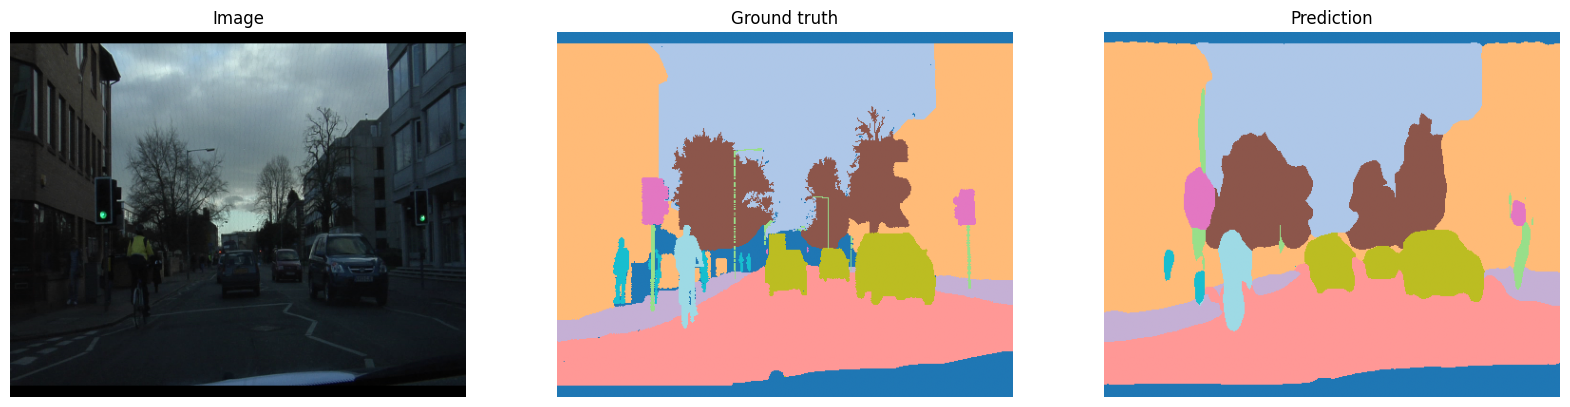

In [6]:
model_fp32 = CamVidModel(
    "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES
)
model_fp32 = save_load_torch_model(model_fp32, path='originalConv_camvid_model_fp32.pt', save=False)
model_fp32.eval()
visualize_sample(model_fp32, test_loader, images, masks)


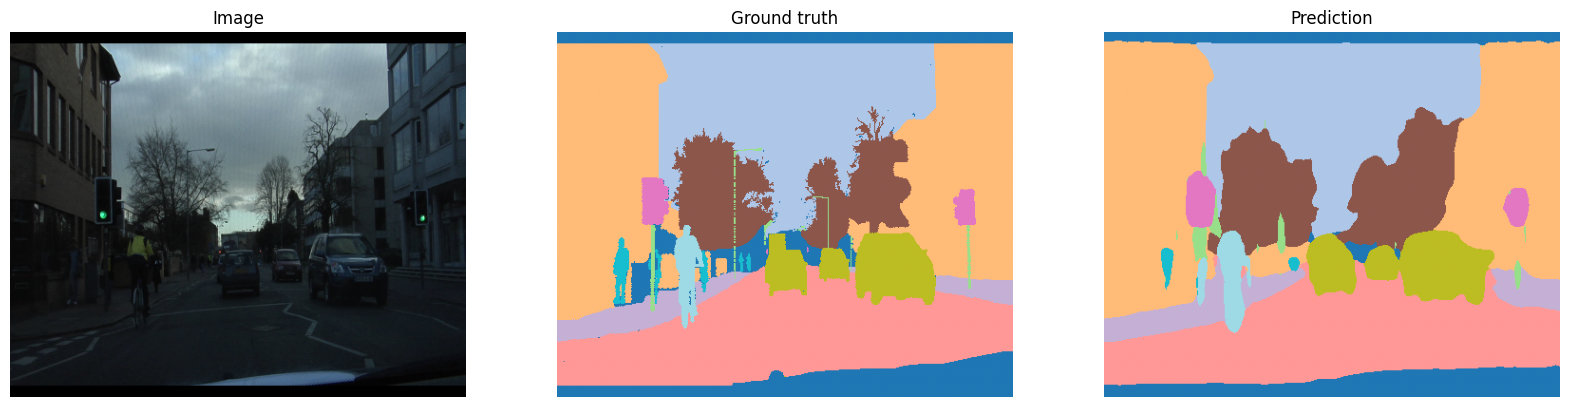

In [7]:
model = CamVidModel(
    "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES
)

model = save_load_torch_model(model, path='originalConv_camvid_model_fp16.pt', save=False)
model.eval()
visualize_sample(model, test_loader, images, masks)

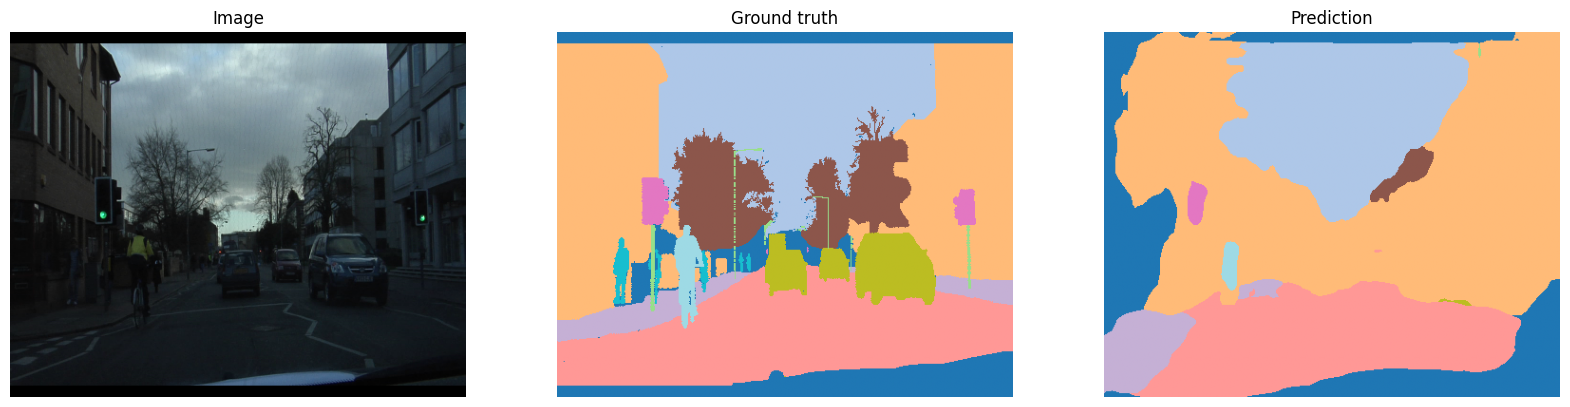

In [9]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model = save_load_torch_model(model, path='originalConv_camvid_model_fp16.pt', save=False)
model.eval()
model.half()
visualize_sample(model.cuda(), test_loader, images.cuda(), masks.cuda())

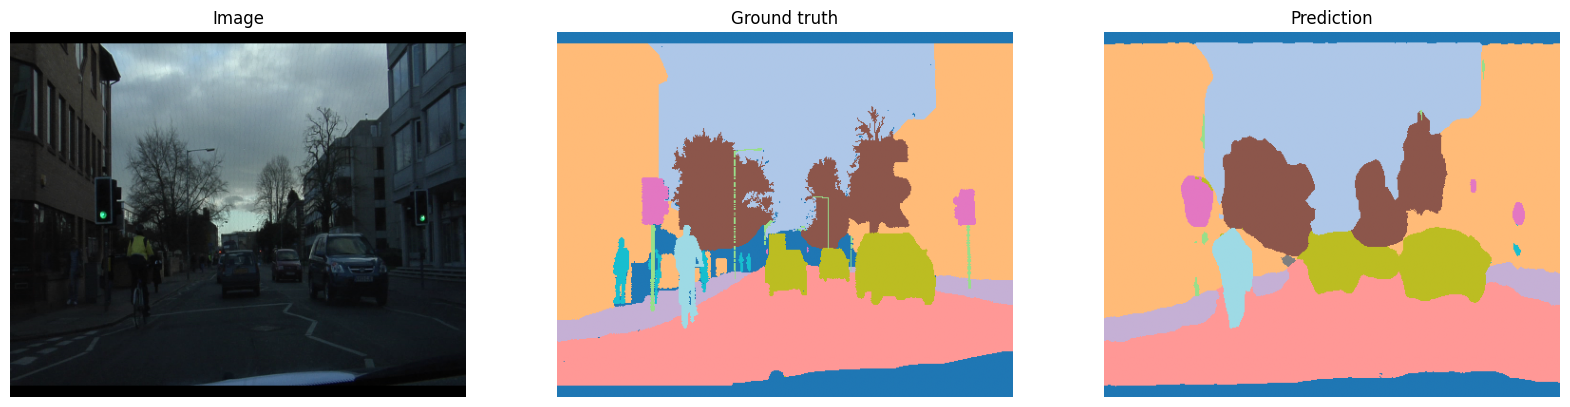

In [16]:
from torch.ao.quantization import get_default_qat_qconfig_mapping
model = CamVidModel( "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model.eval()
prepared_model = copy.deepcopy(model)
prepared_model.eval()
config = get_default_qat_qconfig_mapping("x86")
prepared_model = prepared_model.setup_qat(images, config)
prepared_model.cpu()
save = convert_fx(prepared_model.model)
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model.eval()
model.model = save  # !! `save` in int8

model = save_load_torch_model(model, path='originalConv_camvid_model_int8-qat_x86cfg.pt', save=False)
model.eval()
visualize_sample(model.cpu(), test_loader, images.cpu(), masks.cpu())

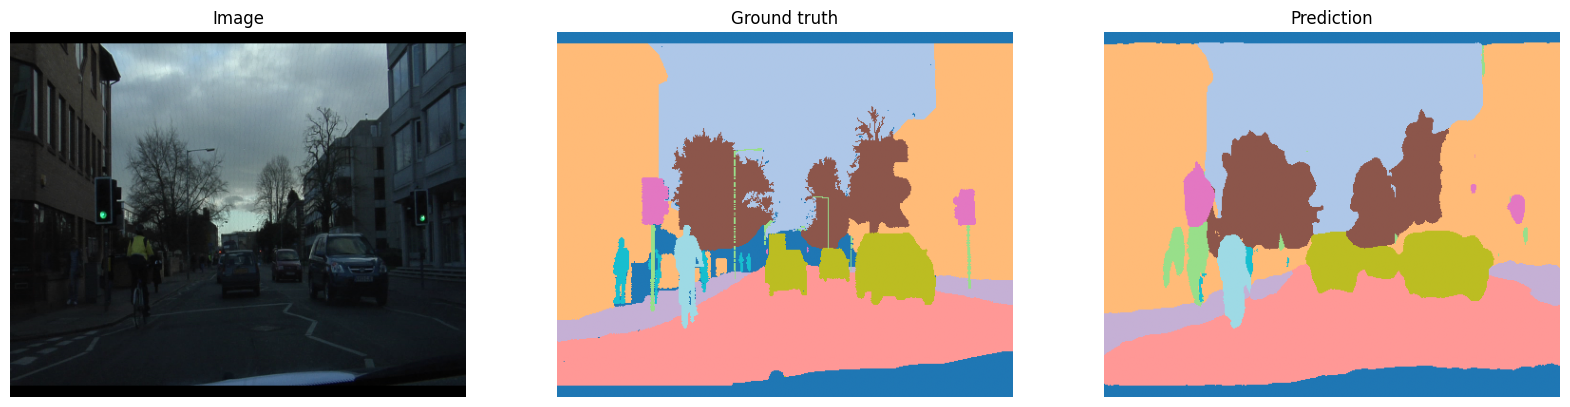

In [17]:
from torch.ao.quantization import get_default_qat_qconfig_mapping
model = CamVidModel( "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model.eval()
prepared_model = copy.deepcopy(model)
prepared_model.eval()
config = get_default_qat_qconfig_mapping("x86")
prepared_model = prepared_model.setup_qat(images, config)
prepared_model.cpu()
save = convert_fx(prepared_model.model)
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model.eval()
model.model = save  # !! `save` in int8

model = save_load_torch_model(model, path='originalConv_camvid_model_int8-qat_x86CustomCfg.pt', save=False)
model.eval()
visualize_sample(model.cpu(), test_loader, images.cpu(), masks.cpu())

#### Custom Conv

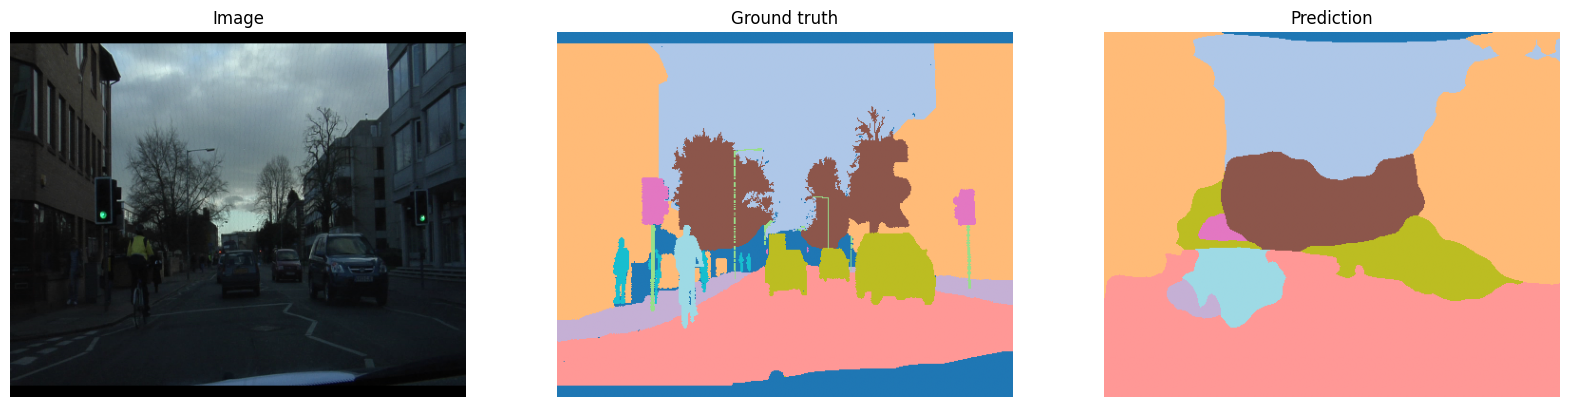

In [10]:
model_fp32 = CamVidModel(
    "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES
)
from experiments.common.replace_conv_resnet import replace_conv2d_with_custom
replace_conv2d_with_custom(model)

model_fp32 = save_load_torch_model(model_fp32, path='replacedConv_camvid_model_fp32.pt', save=False)
model_fp32.eval()
visualize_sample(model_fp32, test_loader, images, masks)

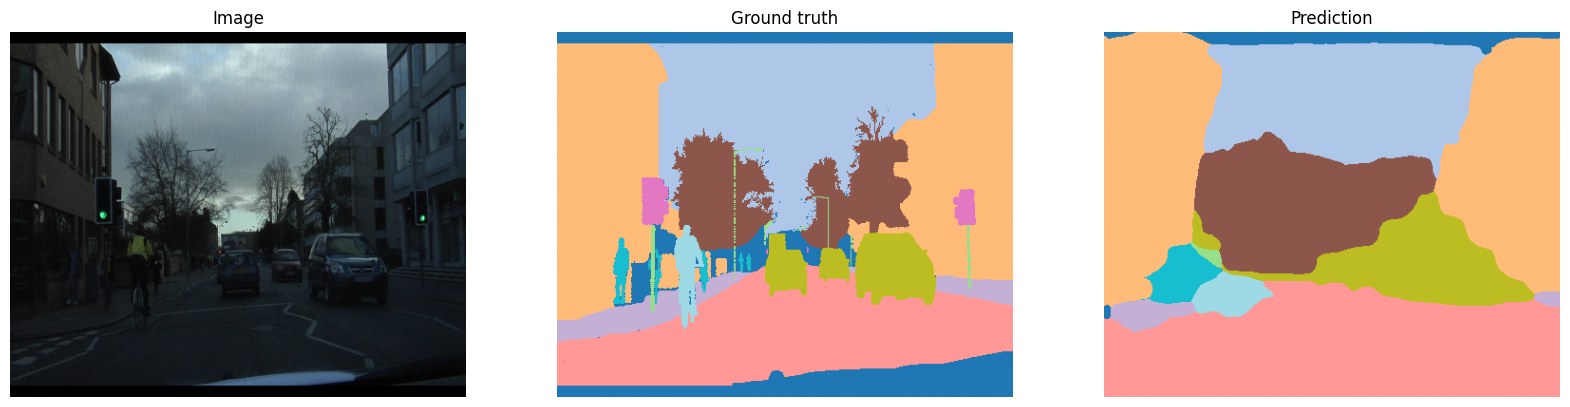

In [14]:
model_fp16 = CamVidModel(  "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
from experiments.common.replace_conv_resnet import replace_conv2d_with_custom
replace_conv2d_with_custom(model_fp16)
model_fp16 = save_load_torch_model(model_fp16, path='replacedConv_camvid_model_fp16.pt', save=False)
model_fp16.eval()
visualize_sample(model_fp16, test_loader, images.cpu(), masks.cpu())

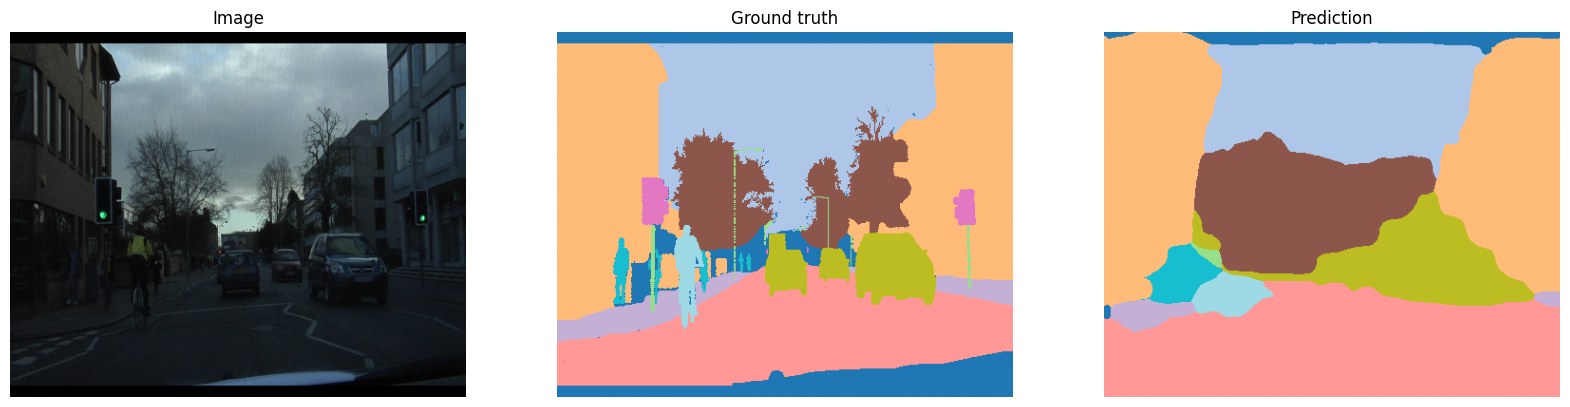

In [15]:
model_fp16 = CamVidModel(  "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
from experiments.common.replace_conv_resnet import replace_conv2d_with_custom
replace_conv2d_with_custom(model_fp16)
model_fp16 = save_load_torch_model(model_fp16, path='replacedConv_camvid_model_fp16.pt', save=False)
model_fp16.eval()
model.half()
visualize_sample(model_fp16.cuda(), test_loader, images.cuda(), masks.cuda())

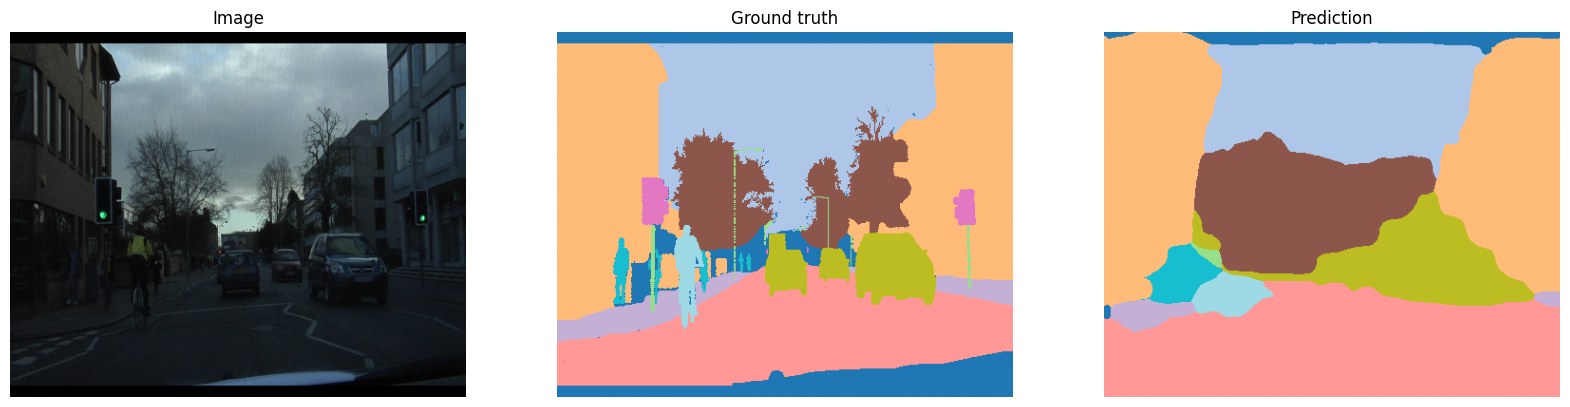

In [18]:
from torch.ao.quantization import get_default_qat_qconfig_mapping
from lightning_fabric.utilities.cloud_io import _load as pl_load
model = CamVidModel( "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
from experiments.common.replace_conv_resnet import replace_conv2d_with_custom
replace_conv2d_with_custom(model)
model.eval()
prepared_model = copy.deepcopy(model)
prepared_model.eval()
config = get_default_qat_qconfig_mapping("x86")
prepared_model = prepared_model.setup_qat(images, config)
prepared_model.cpu()
save = convert_fx(prepared_model.model)
model = CamVidModel( "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model.eval()
model.model = save  # !! `save` in int8
model = save_load_torch_model(model, path='replacedConv_camvid_model_int8-qat_x86cfg.pt', save=False)
model.eval()
visualize_sample(model_fp16.cuda(), test_loader, images.cuda(), masks.cuda())

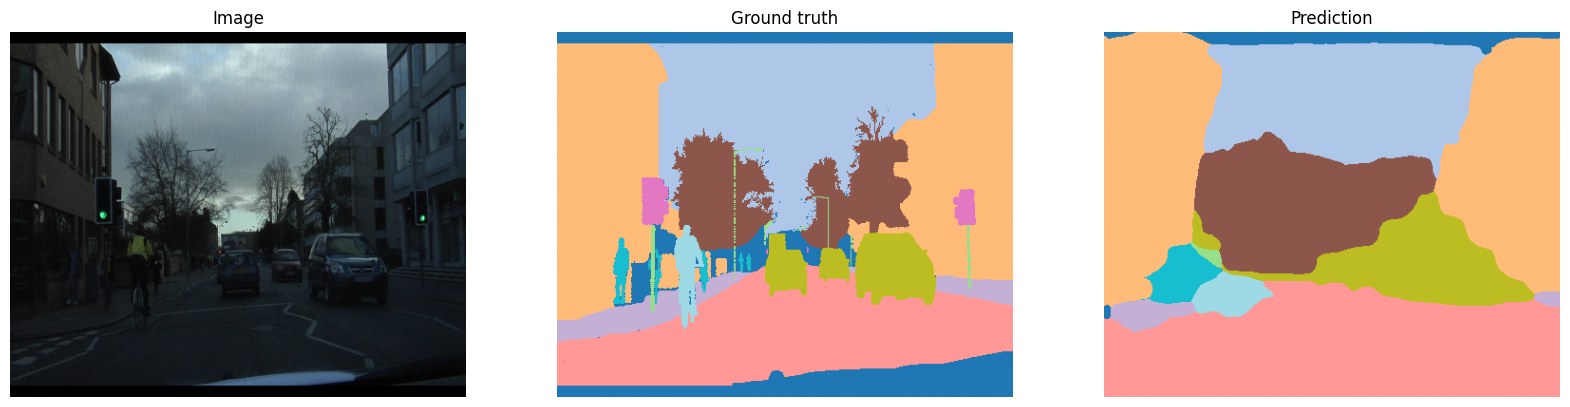

In [19]:
from torch.ao.quantization import get_default_qat_qconfig_mapping
from lightning_fabric.utilities.cloud_io import _load as pl_load
model = CamVidModel( "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
from experiments.common.replace_conv_resnet import replace_conv2d_with_custom
replace_conv2d_with_custom(model)
model.eval()
prepared_model = copy.deepcopy(model)
prepared_model.eval()
config = get_default_qat_qconfig_mapping("x86")
prepared_model = prepared_model.setup_qat(images, config)
prepared_model.cpu()
save = convert_fx(prepared_model.model)
model = CamVidModel( "FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model.eval()
model.model = save  # !! `save` in int8
model = save_load_torch_model(model, path='replacedConv_camvid_model_int8-qat_x86CustomCfg.pt', save=False)
model.eval()
visualize_sample(model_fp16.cuda(), test_loader, images.cuda(), masks.cuda())

## Eval Latency + Accuracy CamVidModel

In [5]:
writer = LatencyMetricsWriter("OrigCamVidModel_model_benchmark.csv")
input_ = next(iter(valid_loader))[0]
print(input_.device)
print(input_.shape)
input_ = torch.ones([1, 3, 128, 128], dtype = input_.dtype, device = input_.device)

print(input_.device)
print(input_.shape)

cpu
torch.Size([8, 3, 384, 480])
cpu
torch.Size([1, 3, 128, 128])


### Original Conv ==  Eval Latency + Accuracy CamVidModel

In [7]:
# model_ckpt = "originalConv_camvid_model_fp32.pt"
# if_custom = "replaced" in model_ckpt
# tf_32 = "tf32" in model_ckpt
# evaluate_model_performance_fp32_tf32(
#     model_ckpt, input_, writer, if_custom, tf_32, bs_range=[64, 128]
# )

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



[{'valid_per_image_iou': 0.8499692678451538, 'valid_dataset_iou': 0.8496010899543762}]
Testing DataLoader 0: 100%|██████████| 30/30 [00:18<00:00,  1.62it/s]
[{'test_per_image_iou': 0.7844766974449158, 'test_dataset_iou': 0.782253086566925}]


STAGE:2025-11-16 09:51:01 700:700 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 09:51:06 700:700 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 09:51:06 700:700 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([64, 3, 128, 128]) cuda:0
84.940ms +- 9.459ms
Metrics recorded for CamVidModel (batch_size=64)


STAGE:2025-11-16 09:51:15 700:700 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


: 

In [8]:
# model_ckpt = "originalConvcamvid_model_tf32.pt"
# if_custom = "replaced" in model_ckpt
# tf_32 = "tf32" in model_ckpt
# evaluate_model_performance_fp32_tf32(
#     model_ckpt, input_, writer, if_custom, tf_32, bs_range=[1, 2, 4, 8, 16, 32, 64]
# )

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 13/13 [00:11<00:00,  1.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'valid_per_image_iou': 0.8400639295578003, 'valid_dataset_iou': 0.8394758701324463}]
Testing DataLoader 0: 100%|██████████| 30/30 [00:26<00:00,  1.14it/s]
[{'test_per_image_iou': 0.7658573389053345, 'test_dataset_iou': 0.7630212903022766}]


STAGE:2025-11-16 09:53:36 1315:1315 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 09:53:37 1315:1315 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 09:53:37 1315:1315 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([1, 3, 128, 128]) cuda:0
19.007ms +- 6.535ms
Metrics recorded for CamVidModel (batch_size=1)


STAGE:2025-11-16 09:53:39 1315:1315 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 09:53:39 1315:1315 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 09:53:39 1315:1315 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([2, 3, 128, 128]) cuda:0
17.303ms +- 5.869ms
Metrics recorded for CamVidModel (batch_size=2)


STAGE:2025-11-16 09:53:40 1315:1315 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 09:53:41 1315:1315 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 09:53:41 1315:1315 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([4, 3, 128, 128]) cuda:0
21.609ms +- 8.063ms
Metrics recorded for CamVidModel (batch_size=4)


STAGE:2025-11-16 09:53:42 1315:1315 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 09:53:43 1315:1315 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 09:53:43 1315:1315 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([8, 3, 128, 128]) cuda:0
21.675ms +- 7.305ms
Metrics recorded for CamVidModel (batch_size=8)


STAGE:2025-11-16 09:53:46 1315:1315 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 09:53:48 1315:1315 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 09:53:48 1315:1315 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([16, 3, 128, 128]) cuda:0
27.185ms +- 7.108ms
Metrics recorded for CamVidModel (batch_size=16)


STAGE:2025-11-16 09:53:50 1315:1315 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 09:53:52 1315:1315 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 09:53:52 1315:1315 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([32, 3, 128, 128]) cuda:0
47.644ms +- 5.949ms
Metrics recorded for CamVidModel (batch_size=32)


STAGE:2025-11-16 09:54:08 1315:1315 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


: 

In [7]:
# model_ckpt = "originalConv_camvid_model_fp16.pt"
# do_half = True
# if_custom = "replaced" in model_ckpt
# evaluate_model_performance_fp16(
#     model_ckpt, input_, writer, do_half, if_custom, bs_range=[1, 2, 4, 8, 16, 32, 64, 128]
# )

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



[{'valid_per_image_iou': 0.44937971234321594, 'valid_dataset_iou': 0.4484223425388336}]
Testing DataLoader 0: 100%|██████████| 30/30 [00:22<00:00,  1.31it/s]
[{'test_per_image_iou': 0.4054091274738312, 'test_dataset_iou': 0.40071555972099304}]
Start GPU benchmark with input shape: torch.Size([1, 3, 128, 128]) cuda:0
16.527ms +- 4.649ms
Metrics recorded for CamVidModel_half (batch_size=1)
Start GPU benchmark with input shape: torch.Size([2, 3, 128, 128]) cuda:0
14.944ms +- 6.068ms
Metrics recorded for CamVidModel_half (batch_size=2)
Start GPU benchmark with input shape: torch.Size([4, 3, 128, 128]) cuda:0
15.395ms +- 5.981ms
Metrics recorded for CamVidModel_half (batch_size=4)
Start GPU benchmark with input shape: torch.Size([8, 3, 128, 128]) cuda:0
18.357ms +- 7.864ms
Metrics recorded for CamVidModel_half (batch_size=8)
Start GPU benchmark with input shape: torch.Size([16, 3, 128, 128]) cuda:0
19.318ms +- 6.120ms
Metrics recorded for CamVidModel_half (batch_size=16)
Start GPU benchmar

In [8]:
# model_ckpt = "originalConv_camvid_model_fp16.pt"
# do_half = False
# if_custom = "replaced" in model_ckpt
# evaluate_model_performance_fp16(
#     model_ckpt, input_, writer, do_half, if_custom, bs_range=[1, 2, 4, 8, 16, 32, 64, 128]
# )

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



[{'valid_per_image_iou': 0.8421237468719482, 'valid_dataset_iou': 0.841702938079834}]
Testing DataLoader 0: 100%|██████████| 30/30 [00:23<00:00,  1.26it/s]
[{'test_per_image_iou': 0.7648636102676392, 'test_dataset_iou': 0.7624585032463074}]


STAGE:2025-11-16 09:57:11 2090:2090 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 09:57:12 2090:2090 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 09:57:12 2090:2090 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([1, 3, 128, 128]) cuda:0
19.332ms +- 8.394ms
Metrics recorded for CamVidModel (batch_size=1)


STAGE:2025-11-16 09:57:14 2090:2090 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 09:57:14 2090:2090 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 09:57:14 2090:2090 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([2, 3, 128, 128]) cuda:0
22.870ms +- 9.821ms
Metrics recorded for CamVidModel (batch_size=2)


STAGE:2025-11-16 09:57:16 2090:2090 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 09:57:16 2090:2090 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 09:57:16 2090:2090 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([4, 3, 128, 128]) cuda:0
20.158ms +- 7.405ms
Metrics recorded for CamVidModel (batch_size=4)


STAGE:2025-11-16 09:57:18 2090:2090 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 09:57:18 2090:2090 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 09:57:18 2090:2090 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([8, 3, 128, 128]) cuda:0
21.926ms +- 6.750ms
Metrics recorded for CamVidModel (batch_size=8)


STAGE:2025-11-16 09:57:20 2090:2090 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 09:57:21 2090:2090 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 09:57:21 2090:2090 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([16, 3, 128, 128]) cuda:0
26.034ms +- 5.738ms
Metrics recorded for CamVidModel (batch_size=16)


STAGE:2025-11-16 09:57:23 2090:2090 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 09:57:27 2090:2090 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 09:57:27 2090:2090 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([32, 3, 128, 128]) cuda:0
48.414ms +- 11.111ms
Metrics recorded for CamVidModel (batch_size=32)


STAGE:2025-11-16 09:57:42 2090:2090 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


: 

In [ ]:
# model_ckpt = "originalConv_camvid_model_int8-qat_x86cfg.pt"
# if_custom = "replaced" in model_ckpt

# evaluate_model_performance_int8(
#     model_ckpt,
#     input_,
#     writer,
#     if_custom,
#     bs_range=[1, 2, 4, 8, 16, 32, 64, 128]

# )

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model Loaded
Validation DataLoader 0: 100%|██████████| 13/13 [00:41<00:00,  0.31it/s]
[{'valid_per_image_iou': 0.7745287418365479, 'valid_dataset_iou': 0.7735828757286072}]
Testing DataLoader 0: 100%|██████████| 30/30 [01:37<00:00,  0.31it/s]
[{'test_per_image_iou': 0.6890323162078857, 'test_dataset_iou': 0.6845455765724182}]


STAGE:2025-11-16 10:01:35 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:01:35 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:01:35 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2025-11-16 10:01:35 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:01:35 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:01:35 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Metrics recorded for CamVidModel (batch_size=1)
Metrics recorded for CamVidModel (batch_size=2)


STAGE:2025-11-16 10:01:35 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:01:36 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:01:36 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2025-11-16 10:01:36 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Metrics recorded for CamVidModel (batch_size=4)


STAGE:2025-11-16 10:01:36 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:01:36 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2025-11-16 10:01:36 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Metrics recorded for CamVidModel (batch_size=8)


STAGE:2025-11-16 10:01:36 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:01:36 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2025-11-16 10:01:36 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Metrics recorded for CamVidModel (batch_size=16)


STAGE:2025-11-16 10:01:37 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:01:37 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2025-11-16 10:01:38 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Metrics recorded for CamVidModel (batch_size=32)


STAGE:2025-11-16 10:01:39 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:01:39 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Metrics recorded for CamVidModel (batch_size=64)


STAGE:2025-11-16 10:01:40 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Metrics recorded for CamVidModel (batch_size=128)


STAGE:2025-11-16 10:01:43 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:01:43 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [8]:
# model_ckpt = "originalConv_camvid_model_int8-qat_x86CustomCfg.pt"
# if_custom = "replaced" in model_ckpt

# evaluate_model_performance_int8(
#     model_ckpt,
#     input_,
#     writer,
#     if_custom,
#     bs_range=[1, 2, 4, 8, 16, 32, 64, 128]

# )

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model Loaded
Validation DataLoader 0: 100%|██████████| 13/13 [00:44<00:00,  0.29it/s]
[{'valid_per_image_iou': 0.8314415812492371, 'valid_dataset_iou': 0.8306630253791809}]
Testing DataLoader 0: 100%|██████████| 30/30 [01:45<00:00,  0.29it/s]
[{'test_per_image_iou': 0.7243770360946655, 'test_dataset_iou': 0.7200798988342285}]
Metrics recorded for CamVidModel (batch_size=1)


STAGE:2025-11-16 10:08:31 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:08:31 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:08:31 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2025-11-16 10:08:31 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:08:31 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:08:31 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2025-11-16 10:08:31 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:08:31 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:08:31 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Metrics recorded for CamVidModel (batch_size=2)
Metrics recorded for CamVidModel (batch_size=4)


STAGE:2025-11-16 10:08:31 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:08:31 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:08:31 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Metrics recorded for CamVidModel (batch_size=8)


STAGE:2025-11-16 10:08:31 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:08:32 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:08:32 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2025-11-16 10:08:32 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Metrics recorded for CamVidModel (batch_size=16)


STAGE:2025-11-16 10:08:33 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:08:33 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2025-11-16 10:08:33 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Metrics recorded for CamVidModel (batch_size=32)


STAGE:2025-11-16 10:08:34 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:08:34 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2025-11-16 10:08:34 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Metrics recorded for CamVidModel (batch_size=64)
Metrics recorded for CamVidModel (batch_size=128)


STAGE:2025-11-16 10:08:37 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:08:37 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


### Replaced Conv ==  Eval Latency + Accuracy CamVidModel

In [5]:
writer = LatencyMetricsWriter("ReplacedCamVidModel_model_benchmark.csv")
input_ = next(iter(valid_loader))[0]
print(input_.device)
print(input_.shape)
input_ = torch.ones([1, 3, 128, 128], dtype = input_.dtype, device = input_.device)

print(input_.device)
print(input_.shape)

cpu
torch.Size([8, 3, 384, 480])
cpu
torch.Size([1, 3, 128, 128])


In [ ]:
# model_ckpt = "replacedConv_camvid_model_fp32.pt"
# if_custom = "replaced" in model_ckpt
# tf_32 = "tf32" in model_ckpt
# evaluate_model_performance_fp32_tf32(
#     model_ckpt, input_, writer, if_custom, tf_32, bs_range=[1, 2, 4, 8, 16, 32, 64]
# )

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 13/13 [00:11<00:00,  1.12it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



[{'valid_per_image_iou': 0.5913413763046265, 'valid_dataset_iou': 0.5902271270751953}]
Testing DataLoader 0: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
[{'test_per_image_iou': 0.548675000667572, 'test_dataset_iou': 0.5446076989173889}]


STAGE:2025-11-16 10:10:03 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:10:03 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:10:03 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([1, 3, 128, 128]) cuda:0
70.726ms +- 20.107ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=1)


STAGE:2025-11-16 10:10:09 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:10:09 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:10:09 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([2, 3, 128, 128]) cuda:0
78.112ms +- 21.278ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=2)


STAGE:2025-11-16 10:10:15 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:10:16 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:10:16 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([4, 3, 128, 128]) cuda:0
78.593ms +- 24.785ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=4)


STAGE:2025-11-16 10:10:22 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:10:23 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:10:23 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([8, 3, 128, 128]) cuda:0
77.856ms +- 17.099ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=8)


STAGE:2025-11-16 10:10:30 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:10:33 2908:2908 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:10:33 2908:2908 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([16, 3, 128, 128]) cuda:0
85.018ms +- 26.868ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=16)


STAGE:2025-11-16 10:10:42 2908:2908 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


: 

In [6]:
# model_ckpt = "replacedConvcamvid_model_tf32.pt"
# if_custom = "replaced" in model_ckpt
# tf_32 = "tf32" in model_ckpt
# evaluate_model_performance_fp32_tf32(
#     model_ckpt, input_, writer, if_custom, tf_32, bs_range=[1, 2, 4, 8, 16, 32, 64]
# )

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



[{'valid_per_image_iou': 0.5924646854400635, 'valid_dataset_iou': 0.5918936133384705}]
Testing DataLoader 0: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s]
[{'test_per_image_iou': 0.5091538429260254, 'test_dataset_iou': 0.5051252245903015}]


STAGE:2025-11-16 10:12:08 5953:5953 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:12:08 5953:5953 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:12:08 5953:5953 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([1, 3, 128, 128]) cuda:0
82.279ms +- 22.307ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=1)


STAGE:2025-11-16 10:12:15 5953:5953 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:12:15 5953:5953 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:12:15 5953:5953 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([2, 3, 128, 128]) cuda:0
73.576ms +- 18.390ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=2)


STAGE:2025-11-16 10:12:21 5953:5953 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:12:21 5953:5953 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:12:21 5953:5953 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([4, 3, 128, 128]) cuda:0
76.947ms +- 20.605ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=4)


STAGE:2025-11-16 10:12:27 5953:5953 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:12:28 5953:5953 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:12:28 5953:5953 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([8, 3, 128, 128]) cuda:0
75.385ms +- 23.963ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=8)


STAGE:2025-11-16 10:12:35 5953:5953 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:12:37 5953:5953 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:12:37 5953:5953 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([16, 3, 128, 128]) cuda:0
81.723ms +- 24.417ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=16)


STAGE:2025-11-16 10:12:45 5953:5953 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:12:48 5953:5953 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:12:48 5953:5953 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([32, 3, 128, 128]) cuda:0
92.418ms +- 20.952ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=32)


STAGE:2025-11-16 10:12:57 5953:5953 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


: 

In [7]:
# model_ckpt = "replacedConv_camvid_model_fp16.pt"
# do_half = False
# if_custom = "replaced" in model_ckpt
# evaluate_model_performance_fp16(
#     model_ckpt, input_, writer, do_half, if_custom, bs_range=[1, 2, 4, 8, 16, 32, 64, 128]
# )

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 13/13 [00:11<00:00,  1.14it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



[{'valid_per_image_iou': 0.5931510329246521, 'valid_dataset_iou': 0.5924107432365417}]
Testing DataLoader 0: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s]
[{'test_per_image_iou': 0.5067890882492065, 'test_dataset_iou': 0.5035204291343689}]


STAGE:2025-11-16 10:14:17 6497:6497 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:14:17 6497:6497 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:14:17 6497:6497 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([1, 3, 128, 128]) cuda:0
74.560ms +- 19.537ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=1)


STAGE:2025-11-16 10:14:23 6497:6497 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:14:23 6497:6497 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:14:23 6497:6497 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([2, 3, 128, 128]) cuda:0
78.763ms +- 21.968ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=2)


STAGE:2025-11-16 10:14:30 6497:6497 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:14:30 6497:6497 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:14:30 6497:6497 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([4, 3, 128, 128]) cuda:0
78.975ms +- 21.685ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=4)


STAGE:2025-11-16 10:14:37 6497:6497 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:14:38 6497:6497 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:14:38 6497:6497 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([8, 3, 128, 128]) cuda:0
72.466ms +- 20.000ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=8)


STAGE:2025-11-16 10:14:45 6497:6497 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:14:47 6497:6497 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:14:47 6497:6497 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([16, 3, 128, 128]) cuda:0
83.546ms +- 22.343ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=16)


STAGE:2025-11-16 10:14:53 6497:6497 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:14:57 6497:6497 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:14:57 6497:6497 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start GPU benchmark with input shape: torch.Size([32, 3, 128, 128]) cuda:0
92.414ms +- 24.360ms
Metrics recorded for ReplacedConv_CamVidModel (batch_size=32)


STAGE:2025-11-16 10:15:06 6497:6497 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


: 

In [6]:
# model_ckpt = "replacedConv_camvid_model_fp16.pt"
# do_half = True
# if_custom = "replaced" in model_ckpt
# evaluate_model_performance_fp16(
#     model_ckpt, input_, writer, do_half, if_custom, bs_range=[1, 2, 4, 8, 16, 32, 64, 128]
# )

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



[{'valid_per_image_iou': 0.28918910026550293, 'valid_dataset_iou': 0.28782063722610474}]
Testing DataLoader 0: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
[{'test_per_image_iou': 0.27505895495414734, 'test_dataset_iou': 0.2703608274459839}]
Start GPU benchmark with input shape: torch.Size([1, 3, 128, 128]) cuda:0
61.831ms +- 16.748ms
Metrics recorded for ReplacedConv_CamVidModel_half (batch_size=1)
Start GPU benchmark with input shape: torch.Size([2, 3, 128, 128]) cuda:0
58.410ms +- 12.670ms
Metrics recorded for ReplacedConv_CamVidModel_half (batch_size=2)
Start GPU benchmark with input shape: torch.Size([4, 3, 128, 128]) cuda:0
57.042ms +- 16.282ms
Metrics recorded for ReplacedConv_CamVidModel_half (batch_size=4)
Start GPU benchmark with input shape: torch.Size([8, 3, 128, 128]) cuda:0
66.963ms +- 18.281ms
Metrics recorded for ReplacedConv_CamVidModel_half (batch_size=8)
Start GPU benchmark with input shape: torch.Size([16, 3, 128, 128]) cuda:0
63.745ms +- 18.966ms
Metrics record

In [ ]:

# model_ckpt = "replacedConv_camvid_model_int8-qat_x86cfg.pt"
# if_custom = "replaced" in model_ckpt

# evaluate_model_performance_int8(
#     model_ckpt,
#     input_,
#     writer,
#     if_custom,
#     bs_range=[1, 2, 4, 8, 16, 32, 64, 128],
#     lightning_module=False

# )

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model Loaded
Validation DataLoader 0: 100%|██████████| 13/13 [02:34<00:00,  0.08it/s]
[{'valid_per_image_iou': 0.841875433921814, 'valid_dataset_iou': 0.841417670249939}]
Testing DataLoader 0: 100%|██████████| 30/30 [05:39<00:00,  0.09it/s]
[{'test_per_image_iou': 0.7417954802513123, 'test_dataset_iou': 0.7385276556015015}]


STAGE:2025-11-16 10:36:33 694:694 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:36:33 694:694 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:36:33 694:694 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Metrics recorded for ReplacedConv_CamVidModel (batch_size=1)


STAGE:2025-11-16 10:36:41 694:694 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:36:41 694:694 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:36:41 694:694 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Metrics recorded for ReplacedConv_CamVidModel (batch_size=2)


STAGE:2025-11-16 10:36:45 694:694 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:36:45 694:694 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:36:45 694:694 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Metrics recorded for ReplacedConv_CamVidModel (batch_size=4)


STAGE:2025-11-16 10:36:49 694:694 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:36:50 694:694 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:36:50 694:694 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Metrics recorded for ReplacedConv_CamVidModel (batch_size=8)


STAGE:2025-11-16 10:36:53 694:694 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:36:56 694:694 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:36:56 694:694 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Metrics recorded for ReplacedConv_CamVidModel (batch_size=16)


STAGE:2025-11-16 10:36:59 694:694 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


: 

In [6]:
model_ckpt = "replacedConv_camvid_model_int8-qat_x86CustomCfg.pt"
if_custom = "replaced" in model_ckpt

evaluate_model_performance_int8(
    model_ckpt,
    input_,
    writer,
    if_custom,
    bs_range=[1, 2, 4, 8, 16, 32, 64, 128],
    lightning_module=False

)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model Loaded
Validation DataLoader 0: 100%|██████████| 13/13 [02:35<00:00,  0.08it/s]
[{'valid_per_image_iou': 0.7786662578582764, 'valid_dataset_iou': 0.7783040404319763}]
Testing DataLoader 0: 100%|██████████| 30/30 [05:46<00:00,  0.09it/s]
[{'test_per_image_iou': 0.7152863144874573, 'test_dataset_iou': 0.7127318978309631}]


STAGE:2025-11-16 10:54:37 5601:5601 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:54:37 5601:5601 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:54:37 5601:5601 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Metrics recorded for ReplacedConv_CamVidModel (batch_size=1)


STAGE:2025-11-16 10:54:53 5601:5601 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:54:53 5601:5601 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:54:53 5601:5601 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Metrics recorded for ReplacedConv_CamVidModel (batch_size=2)


STAGE:2025-11-16 10:54:57 5601:5601 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:54:57 5601:5601 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:54:57 5601:5601 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Metrics recorded for ReplacedConv_CamVidModel (batch_size=4)


STAGE:2025-11-16 10:55:03 5601:5601 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:55:03 5601:5601 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:55:03 5601:5601 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Metrics recorded for ReplacedConv_CamVidModel (batch_size=8)


STAGE:2025-11-16 10:55:07 5601:5601 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-11-16 10:55:09 5601:5601 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-11-16 10:55:09 5601:5601 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Metrics recorded for ReplacedConv_CamVidModel (batch_size=16)


STAGE:2025-11-16 10:55:13 5601:5601 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


: 

## Vizualise

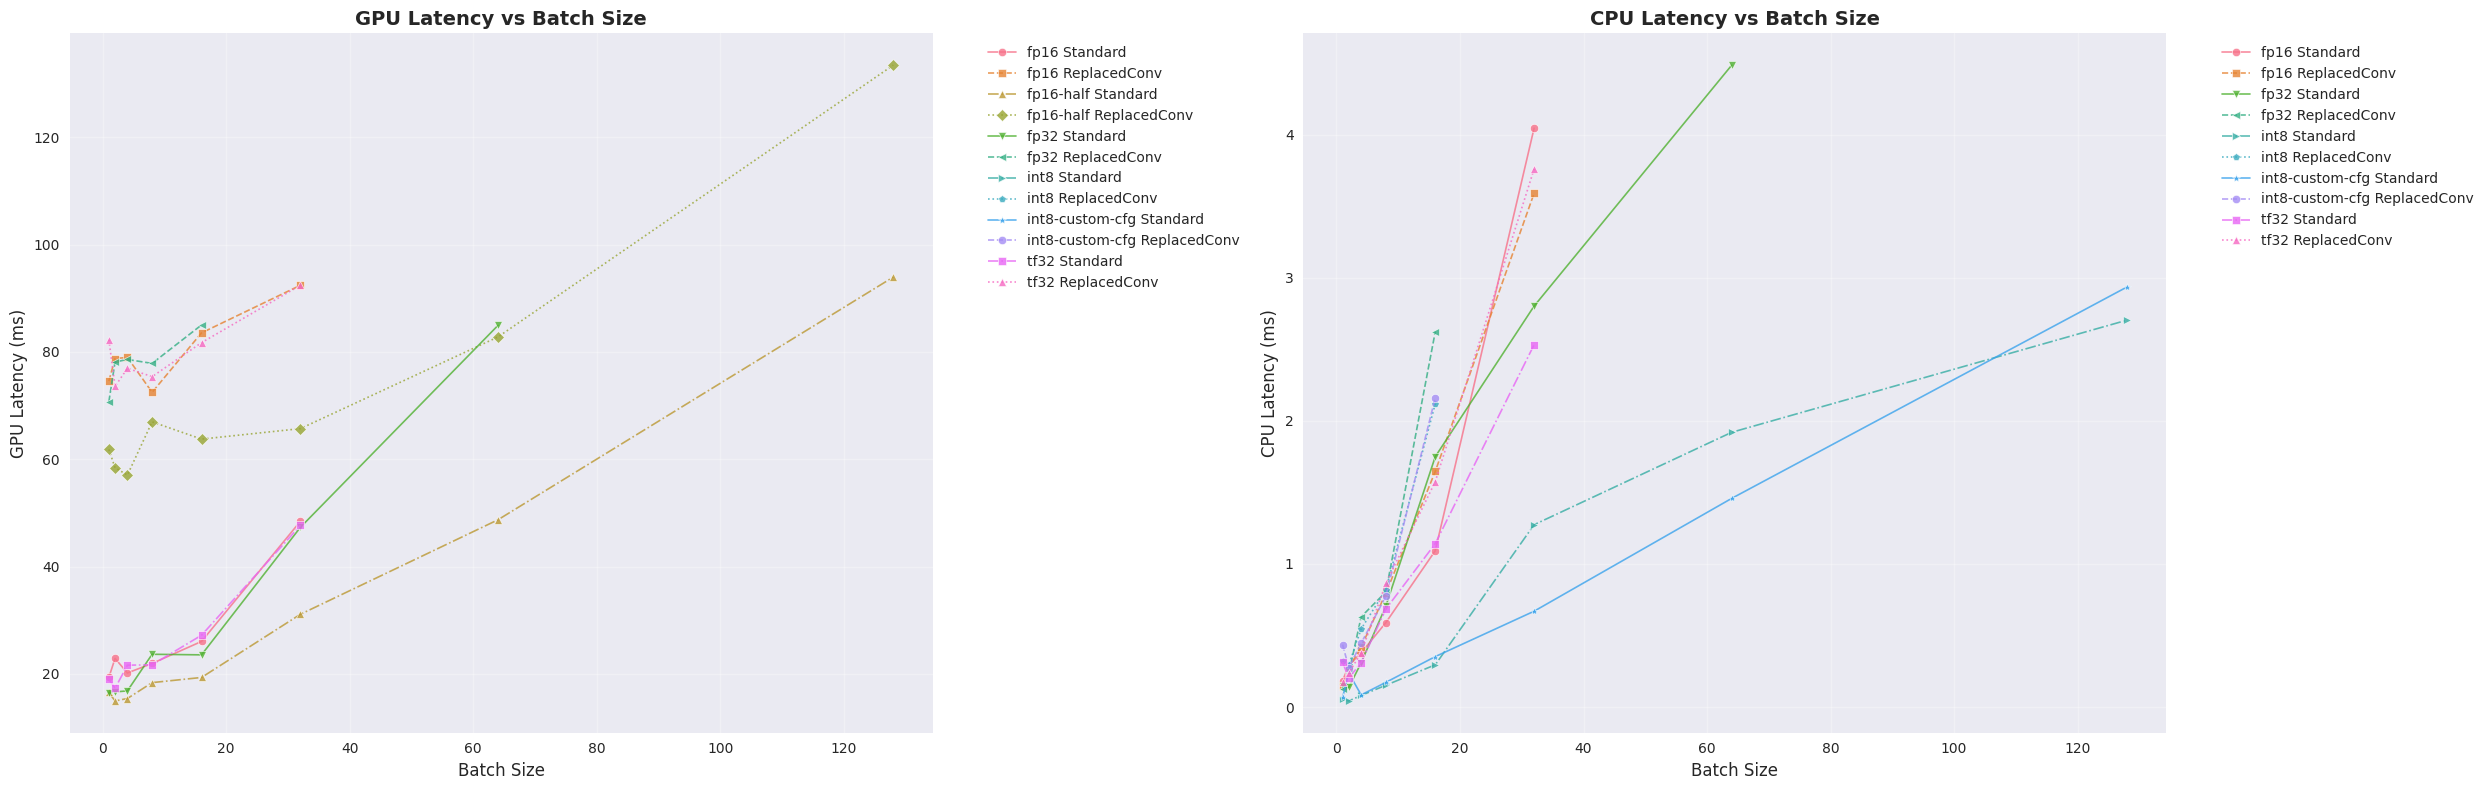

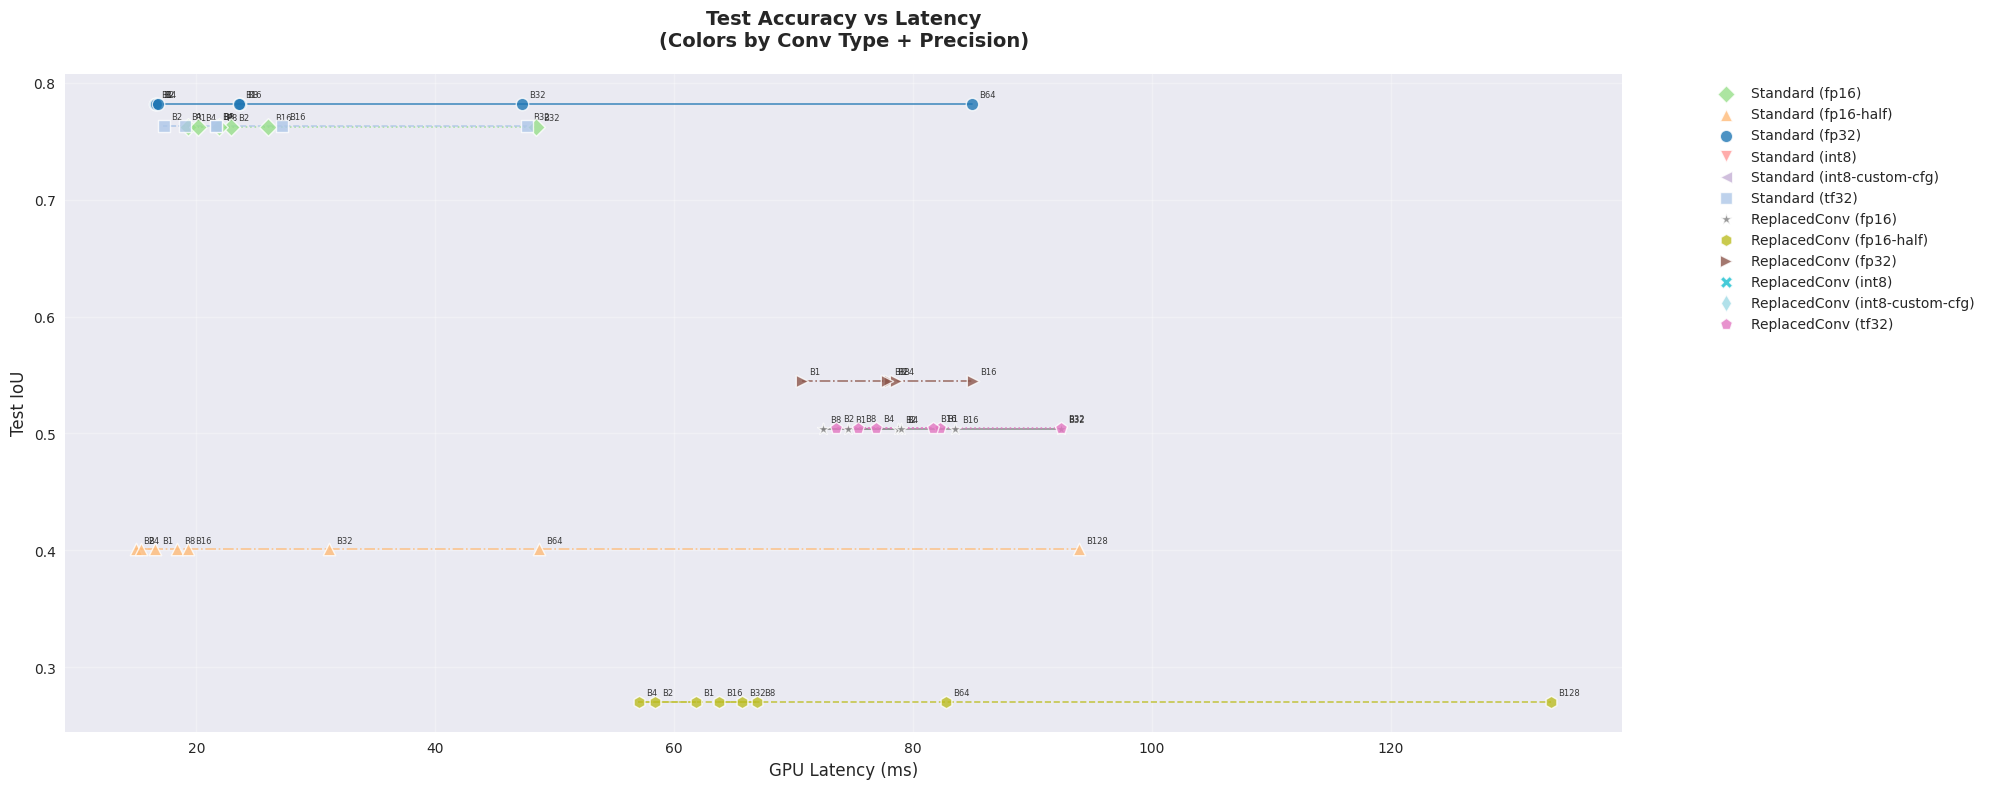

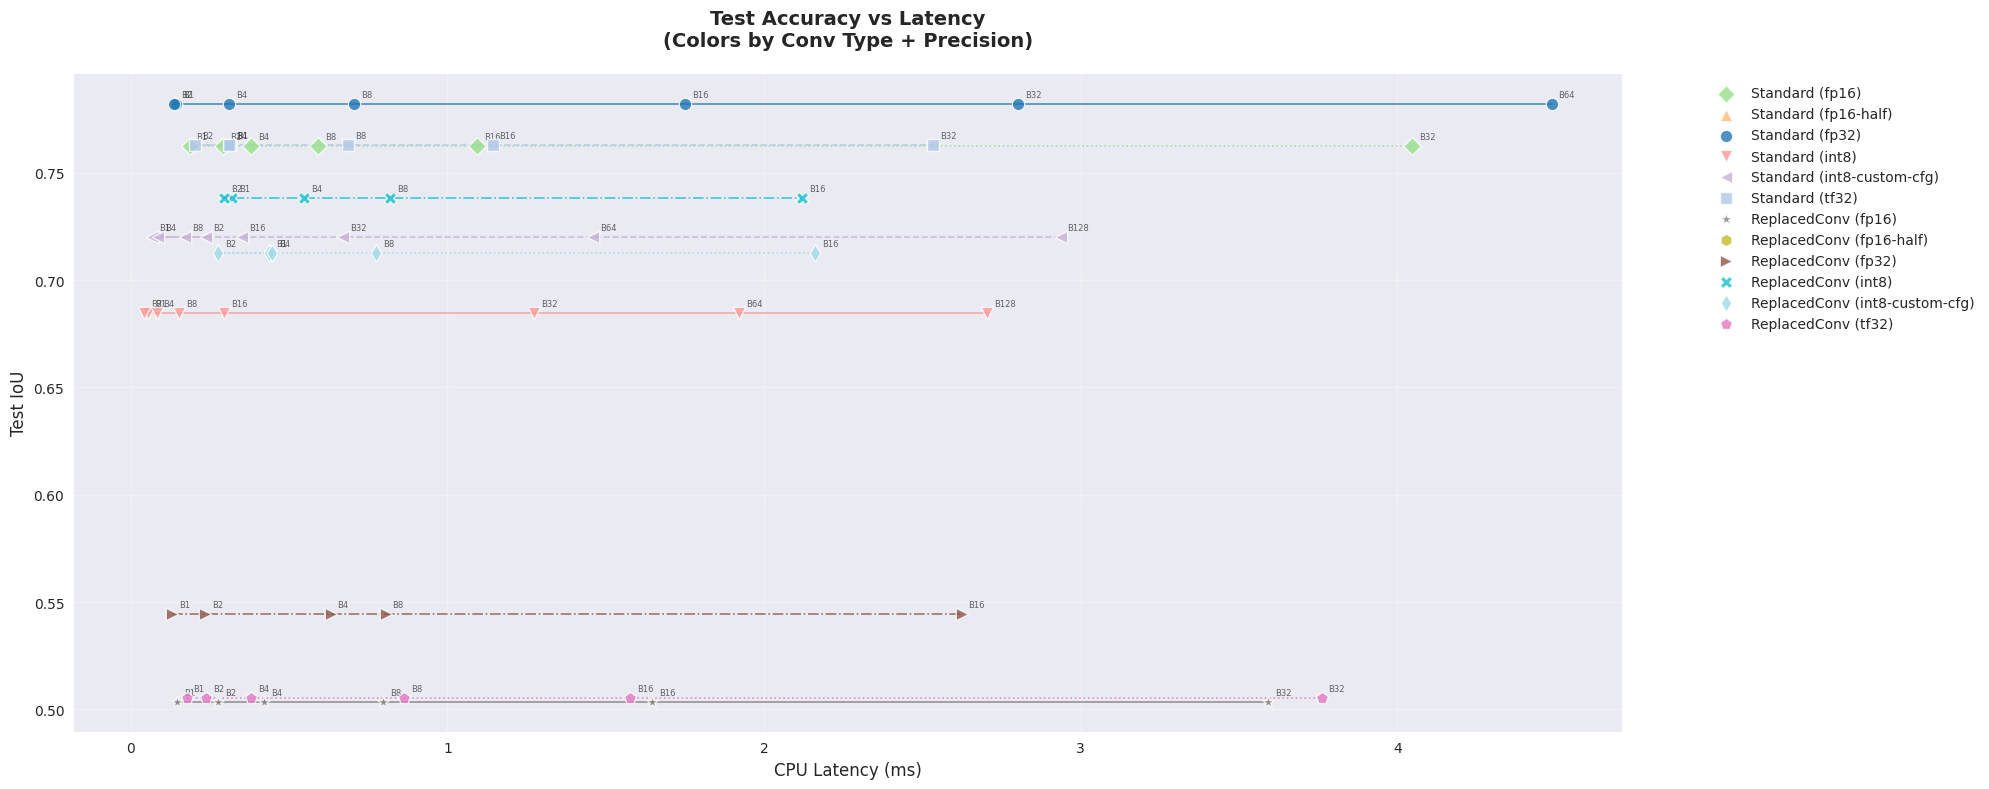

In [5]:
plots, summary, processed_df = analyze_benchmark_data('CamVidModel_model_benchmark.csv')